# Online meta-planner implementation and simulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib.colors as colors
from datetime import datetime
from scipy import stats
import pickle
from joypy import joyplot
from matplotlib.patches import Patch
import pandas as pd
import json

In [2]:
# Increase font size a bit
plt.rcParams.update({'font.size': 16})

## Functions for generative model and inference

In [3]:
"""
Given a set of parameters, returns the retrospective and myopic measurements as well as the prior
"""
def gen_model_init(num_actions, sigma_0, sigma_retro, sigma, Poisson_rate = 2, no_retro = False):
    
    # Draw num_actions samples from the true Q distribution (prior)
    prior = np.random.normal(0, sigma_0, num_actions)
    
    # Can turn off retrospective experiences
    if no_retro == False:
        
        # Generate n experiences with action a in state s (noisy measurements of the prior)
        q_retro_all = []
        qbar_retro_all = np.zeros(num_actions)
        n_samples_all = np.zeros(num_actions)
        for idx, prior_a in enumerate(prior):
            n_samples = np.random.poisson(Poisson_rate)
            q_retro = np.random.normal(prior_a, sigma_retro, n_samples)
            qbar_retro = np.sum(q_retro)

            n_samples_all[idx] = n_samples
            q_retro_all.append(q_retro)
            qbar_retro_all[idx] = qbar_retro
    else:
        qbar_retro_all = np.zeros(num_actions)
        n_samples_all = np.zeros(num_actions)
        
    # Draw the myopic values
    q_1_all = np.random.normal(prior, sigma, num_actions)
    
    return qbar_retro_all, q_1_all, n_samples_all, prior

In [4]:
"""
Given a set of parameters and initial measurements, returns the expected value of looking one step 
ahead for the highest gain action
"""
def inference_action(mu_T, n, num_actions, J, J_T, v_samples):

    V = np.linspace(-10, 10, v_samples)    # range of values for the max distribution
    
    # Update for the single action at T+1
    mu_Tplus1 = mu_T
    var_Tplus1 = np.zeros(num_actions)+0.0000001
    var_Tplus1[n] = (1/(J_T[n]*(1+(J_T[n]/J))))
    
    # -------------------
    # ANALYTICAL SOLUTION
    # -------------------
    # Reset for computation
    F = np.zeros((v_samples, num_actions))
    G = np.zeros((v_samples, num_actions))
    
    # For each action
    for i in range(num_actions):
        F[:,i] = norm.cdf(V, mu_Tplus1[i], np.sqrt(var_Tplus1[i]))
    for j in range(num_actions):
        temp_F = np.copy(F)
        temp_F[:,j] = 1
        G[:,j] = norm.pdf(V, mu_Tplus1[j], np.sqrt(var_Tplus1[j]))*np.prod(temp_F,axis=1)

    max_dist_Tplus1 = np.sum(G, axis=1)
    M_Tplus1 = np.dot(V,(np.sum(G, axis=1)))/np.sum(G)
    
    return mu_Tplus1, var_Tplus1, max_dist_Tplus1, M_Tplus1

## Prospective only simulations

In [134]:
# Set parameters
num_actions = 5
sigma_0 = 1
sigma_retro = 10
sigma = 1
v_samples = 1000              # number of linearly spaced samples for the analytical max distribution
num_sims = 10000

T_steps = 21
T_all = np.arange(1, T_steps, 1)  # number of total time steps to run
T_ranked_all = np.zeros(num_actions)
T_ranked_trajectory = np.zeros((num_actions, T_steps-1, num_sims))

M_T_max_all = np.zeros((T_steps-1, num_sims))

for i in range(num_sims):
    
    var_running = np.ones(num_actions)*(sigma**2)
    
    # Run the generative model
    qbar_retro_all, q_1_all, n_samples_all, prior = gen_model_init(num_actions, sigma_0, sigma_retro, sigma, no_retro = True)
    
    # Array to store value of state based on action that is sampled
    M_T_curr = np.ones(num_actions)
    M_T_max = np.zeros(T_steps-1)

    # Array to store time steps and sigmas
    T_action = np.ones(num_actions)
    
    # Compute useful values ahead of time
    J_0 = 1/sigma_0**2
    J_retro = 1/sigma_retro**2
    J = 1/sigma**2
     
    for T in T_all:
        
        # Compute J_a, mu, and sigma^2
        if T == 1:
            J_T = J_0 + J_retro*n_samples_all + J*T_action
            mu_T = (qbar_retro_all*J_retro*n_samples_all + q_1_all*J*T_action)/J_T
            var_running = 1/J_T
        else:
            J_T = 1/var_running
                
        # Loop through each action to consider sampling it
        for n in range(num_actions):
            mu_Tplus1, var_Tplus1, max_dist_Tplus1, M_Tplus1 = inference_action(mu_T, n, num_actions, J, J_T, v_samples)
            M_T_curr[n] = M_Tplus1
        
        # Max gain action
        max_prev = np.max(mu_T)
        gain_value = M_T_curr-max_prev
        max_value = np.max(gain_value)
        max_ind = np.argmax(gain_value)
        M_T_max[T-1] = max_value
        
        # Update the counter for the action that was chosen and the ranked actions
        T_action[max_ind] += 1
        
        mu_T_all_sorted = -np.sort(-mu_T)
        sort_ind = np.where(mu_T_all_sorted == mu_T[max_ind])[0][0]
        T_ranked_all[sort_ind] += 1
        T_ranked_trajectory[sort_ind, T-1, i] += 1
        
        # Update the prospective value of the max gain action
        new_myopic = np.random.normal(prior[max_ind], sigma)
        
        # Update the posterior mean and variance with the new sample
        post_mean = ((mu_T[max_ind]*J_T[max_ind])+(J*new_myopic))/(J_T[max_ind]+J) 
        post_var = 1/(J_T[max_ind]+J)

        mu_T[max_ind] = post_mean
        var_running[max_ind] = post_var
        
    # Save the overall values
    M_T_max_all[:,i] = M_T_max

In [187]:
with open('saved_analyses_online/M_T_max_all.pickle', 'wb') as handle:
    pickle.dump(M_T_max_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('saved_analyses_online/T_ranked_all.pickle', 'wb') as handle:
    pickle.dump(T_ranked_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('saved_analyses_online/T_ranked_trajectory.pickle', 'wb') as handle:
    pickle.dump(T_ranked_trajectory, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
with open('saved_analyses_online/M_T_max_all.pickle', 'rb') as handle:
    M_T_max_all = pickle.load(handle)
    
with open('saved_analyses_online/T_ranked_all.pickle', 'rb') as handle:
    T_ranked_all = pickle.load(handle)
    
with open('saved_analyses_online/T_ranked_trajectory.pickle', 'rb') as handle:
    T_ranked_trajectory = pickle.load(handle)

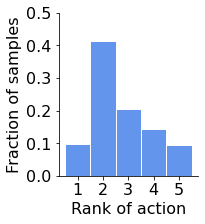

In [64]:
num_actions = 5
num_sims = 10000
T_steps = 21
rank_action = T_ranked_all/(num_sims*T_steps)

# Plot
fig, ax = plt.subplots(figsize=(2.5,3))
ax.bar(np.arange(1,num_actions+1),rank_action,color='cornflowerblue', width=1, edgecolor='white')
ax.set_xticks([1,2,3,4,5])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_xlabel('Rank of action')
ax.set_ylabel('Fraction of samples')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('4A.png', format='png', dpi=1000,bbox_inches = 'tight')

In [47]:
# Compute net value for a few different costs
all_costs = np.linspace(0, 0.2, 11)
M_T_all_total = np.zeros((len(all_costs),len(T_all)))
M_T_all_count = np.zeros((len(all_costs),len(T_all)))

# Loop through the simulations and compute whether it is worthwhile to expand
for i in range(num_sims):
    ind = 0 
    for cost in all_costs:
        for T in T_all:
            curr_value = M_T_max_all[T-1,i]-cost
            if curr_value > 0:
                M_T_all_total[ind, T-1] += 1
            M_T_all_count[ind, T-1] += 1
        ind += 1
        
M_T_all_final = M_T_all_total/M_T_all_count

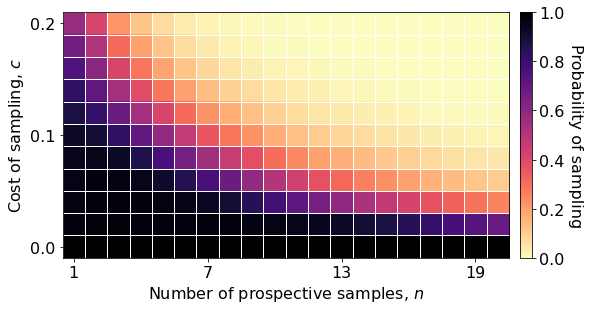

In [58]:
plt.rcParams["figure.figsize"] = (8,6)

fig, ax = plt.subplots()

cmap = plt.get_cmap('magma_r')
im = ax.imshow(M_T_all_final[:,0:20], cmap=cmap, vmin=0, vmax=1)

# Create colorbar
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
colorbar = plt.colorbar(im, cax=cax)
colorbar.ax.set_ylabel('Probability of sampling', rotation=-90, va="bottom") 

# Axis labels
ax.set_xticks(np.arange(0,len(T_all)+1,6))
ax.set_yticks(np.arange(0,len(all_costs)+1,5))
ax.set_xticklabels(np.arange(T_all[0],T_all[19],6))
ax.set_yticklabels(np.arange(all_costs[0],all_costs[-1]+.000001,0.1))
ax.set_xlabel('Number of prospective samples, $\it{n}$')
ax.set_ylabel('Cost of sampling, $c$')

# # Create gridlines
ax.set_xticks(np.arange(len(T_all)+1)-.5, minor=True)
ax.set_yticks(np.arange(len(all_costs)+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)

# Flip the y axis
ax.set_ylim(ax.get_ylim()[::-1])
    
# plt.savefig('S1A.png', format='png', dpi=1000,bbox_inches = 'tight')

## Gap simulations

In [108]:
# Set parameters
num_actions = np.array([2,5,10])
sigma_0 = 1
sigma_retro = 10
sigma = 1
v_samples = 1000              # number of linearly spaced samples for the analytical max distribution
num_sims = 10000

T_steps = 51
T_all = np.arange(1, T_steps, 1)  # number of total time steps to run

M_T_max_three_actions = np.zeros((T_steps-1, num_sims, len(num_actions)))

for i in range(num_sims):
    for j in range(len(num_actions)):
    
        var_running = np.ones(num_actions[j])*(sigma**2)

        # Run the generative model
        qbar_retro_all, q_1_all, n_samples_all, prior = gen_model_init(num_actions[j], sigma_0, sigma_retro, sigma, no_retro = True)

        # Array to store value of state based on action that is sampled
        M_T_curr = np.ones(num_actions[j])
        M_T_max = np.zeros(T_steps-1)

        # Array to store time steps and sigmas
        T_action = np.ones(num_actions[j])

        # Compute useful values ahead of time
        J_0 = 1/sigma_0**2
        J_retro = 1/sigma_retro**2
        J = 1/sigma**2

        for T in T_all:

            # Compute J_a, mu, and sigma^2
            if T == 1:
                J_T = J_0 + J_retro*n_samples_all + J*T_action
                mu_T = (qbar_retro_all*J_retro*n_samples_all + q_1_all*J*T_action)/J_T
                var_running = 1/J_T
            else:
                J_T = 1/var_running

            # Loop through each action to consider sampling it
            for n in range(num_actions[j]):
                mu_Tplus1, var_Tplus1, max_dist_Tplus1, M_Tplus1 = inference_action(mu_T, n, num_actions[j], J, J_T, v_samples)
                M_T_curr[n] = M_Tplus1

            # Max gain action
            max_prev = np.max(mu_T)
            gain_value = M_T_curr-max_prev
            max_value = np.max(gain_value)
            max_ind = np.argmax(gain_value)
            M_T_max[T-1] = max_value

            # Update the prospective value of the max gain action
            new_myopic = np.random.normal(prior[max_ind], sigma)

            # Update the posterior mean and variance with the new sample
            post_mean = ((mu_T[max_ind]*J_T[max_ind])+(J*new_myopic))/(J_T[max_ind]+J) 
            post_var = 1/(J_T[max_ind]+J)

            mu_T[max_ind] = post_mean
            var_running[max_ind] = post_var

            # Update the counter for the action that was chosen
            T_action[max_ind] += 1

        # Save the overall values
        M_T_max_three_actions[:,i,j] = M_T_max

In [109]:
with open('saved_analyses_online/M_T_max_three_actions.pickle', 'wb') as handle:
    pickle.dump(M_T_max_three_actions, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
with open('saved_analyses_online/M_T_max_three_actions.pickle', 'rb') as handle:
    M_T_max_three_actions = pickle.load(handle)

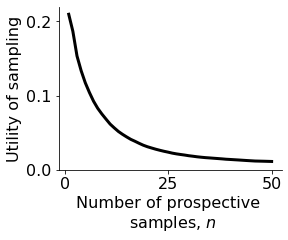

In [7]:
value_action = np.average(M_T_max_three_actions, axis=1)
T_steps = 51

# Plot
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(np.arange(1,T_steps,1),value_action[:,1], color='black', lw=3)
ax.set_xticks([0,25,50])
ax.set_yticks([0,0.1,0.2])
ax.set_xlabel('Number of prospective \n samples, $\it{n}$')
ax.set_ylabel('Utility of sampling')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

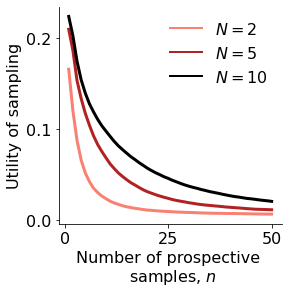

In [9]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))
legend_elements = [Line2D([0], [0], color='salmon', lw=2, label='$N=2$'),  Line2D([0], [0], color='firebrick', lw=2, label='$N=5$'), Line2D([0], [0], color='black', lw=2, label='$N=10$')]
ax.legend(handles=legend_elements, frameon = False, loc='upper right')
ax.plot(np.arange(1,T_steps,1),value_action[:,0], color='salmon', lw=3)
ax.plot(np.arange(1,T_steps,1),value_action[:,1], color='firebrick', lw=3)
ax.plot(np.arange(1,T_steps,1),value_action[:,2], color='black', lw=3)
ax.set_xticks([0,25,50])
ax.set_yticks([0,0.1,0.2])
ax.set_xlabel('Number of prospective \n samples, $\it{n}$')
ax.set_ylabel('Utility of sampling')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('3A.png', format='png', dpi=1000,bbox_inches = 'tight')

In [26]:
# Set parameters
num_actions = 5
sigma_0 = 1
sigma_retro = 10
sigma = 1
v_samples = 1000              # number of linearly spaced samples for the analytical max distribution
num_sims = 1000

T_steps = 11
T_all = np.arange(1, T_steps, 1)  # number of total time steps to run
T_ranked_all = np.zeros(num_actions)
T_ranked_trajectory = np.zeros((num_actions, T_steps-1, num_sims))
gap_dist_rank = np.zeros((T_steps-1, num_sims))

M_T_max_all = np.zeros((T_steps-1, num_sims))

for i in range(num_sims):
    
    var_running = np.ones(num_actions)*(sigma**2)
    
    # Run the generative model
    qbar_retro_all, q_1_all, n_samples_all, prior = gen_model_init(num_actions, sigma_0, sigma_retro, sigma, no_retro = True)
    
    # Array to store value of state based on action that is sampled
    M_T_curr = np.ones(num_actions)
    M_T_max = np.zeros(T_steps-1)

    # Array to store time steps and sigmas
    T_action = np.ones(num_actions)
    
    # Compute useful values ahead of time
    J_0 = 1/sigma_0**2
    J_retro = 1/sigma_retro**2
    J = 1/sigma**2
     
    for T in T_all:
        
        # Compute J_a, mu, and sigma^2
        if T == 1:
            J_T = J_0 + J_retro*n_samples_all + J*T_action
            mu_T = (qbar_retro_all*J_retro*n_samples_all + q_1_all*J*T_action)/J_T
            var_running = 1/J_T
        else:
            J_T = 1/var_running
            
        # Save out the gap (top two options)
        q_1_all_sorted = -np.sort(-mu_T)
        gap_dist_rank[T-1,i] = np.abs(q_1_all_sorted[0]-q_1_all_sorted[1])
                
        # Loop through each action to consider sampling it
        for n in range(num_actions):
            mu_Tplus1, var_Tplus1, max_dist_Tplus1, M_Tplus1 = inference_action(mu_T, n, num_actions, J, J_T, v_samples)
            M_T_curr[n] = M_Tplus1
        
        # Max gain action
        max_prev = np.max(mu_T)
        gain_value = M_T_curr-max_prev
        max_value = np.max(gain_value)
        max_ind = np.argmax(gain_value)
        M_T_max[T-1] = max_value
        
        # Update the counter for the action that was chosen and the ranked actions
        T_action[max_ind] += 1
        
        mu_T_all_sorted = -np.sort(-mu_T)
        sort_ind = np.where(mu_T_all_sorted == mu_T[max_ind])[0][0]
        T_ranked_all[sort_ind] += 1
        T_ranked_trajectory[sort_ind, T-1, i] += 1
        
        # Update the prospective value of the max gain action
        new_myopic = np.random.normal(prior[max_ind], sigma)
        
        # Update the posterior mean and variance with the new sample
        post_mean = ((mu_T[max_ind]*J_T[max_ind])+(J*new_myopic))/(J_T[max_ind]+J) 
        post_var = 1/(J_T[max_ind]+J)

        mu_T[max_ind] = post_mean
        var_running[max_ind] = post_var
        
    # Save the overall values
    M_T_max_all[:,i] = M_T_max

In [27]:
inds1 = np.where(T_ranked_trajectory[0,:,:].flatten()==1)
rank1_gaps = gap_dist_rank.flatten()[inds1]
rank1_M = M_T_max_all.flatten()[inds1]

inds2 = np.where(T_ranked_trajectory[1,:,:].flatten()==1)
rank2_gaps = gap_dist_rank.flatten()[inds2]
rank2_M = M_T_max_all.flatten()[inds2]

inds3 = np.where(T_ranked_trajectory[2,:,:].flatten()==1)
rank3_gaps = gap_dist_rank.flatten()[inds3]
rank3_M = M_T_max_all.flatten()[inds3]

inds4 = np.where(T_ranked_trajectory[3,:,:].flatten()==1)
rank4_gaps = gap_dist_rank.flatten()[inds4]
rank4_M = M_T_max_all.flatten()[inds4]

inds5 = np.where(T_ranked_trajectory[4,:,:].flatten()==1)
rank5_gaps = gap_dist_rank.flatten()[inds5]
rank5_M = M_T_max_all.flatten()[inds5]

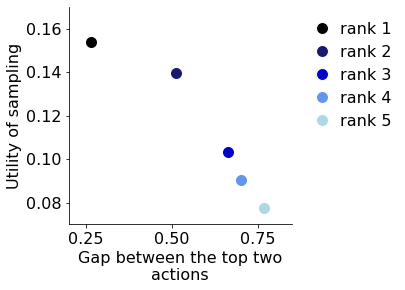

In [29]:
fig, ax = plt.subplots(figsize=(4,4))

legend_elements = [Line2D([0], [0], marker='o', ms=12, markerfacecolor='black', color='w', label='rank 1'),  Line2D([0], [0], marker='o', ms=12, markerfacecolor='midnightblue', color='w', label='rank 2'),
                  Line2D([0], [0], marker='o', ms=12, markerfacecolor='mediumblue', color='w', label='rank 3'), Line2D([0], [0], marker='o', ms=12, markerfacecolor='cornflowerblue', color='w', label='rank 4'),
                  Line2D([0], [0], marker='o', ms=12, markerfacecolor='lightblue', color='w', label='rank 5')]
ax.legend(handles=legend_elements, frameon = False, bbox_to_anchor=(1, 1), loc='upper left', handletextpad=0.1)

ax.scatter(np.average(rank1_gaps), np.average(rank1_M), marker='o', s=100, c='black')
ax.scatter(np.average(rank2_gaps), np.average(rank2_M), marker='o', s=100, c='midnightblue')
ax.scatter(np.average(rank3_gaps), np.average(rank3_M), marker='o', s=100, c='mediumblue')
ax.scatter(np.average(rank4_gaps), np.average(rank4_M), marker='o', s=100, c='cornflowerblue')
ax.scatter(np.average(rank5_gaps), np.average(rank5_M), marker='o', s=100, c='lightblue')
# ax.plot([np.average(rank1_gaps), np.average(rank2_gaps), np.average(rank3_gaps), np.average(rank4_gaps), np.average(rank5_gaps)],
#         [np.average(rank1_M), np.average(rank2_M), np.average(rank3_M), np.average(rank4_M), np.average(rank5_M)], lw=2, color='black', zorder=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0.2,0.85)
ax.set_ylim(0.07,0.17)
ax.set_xticks([0.25,0.5,0.75])
ax.set_yticks([0.08,0.1,0.12,0.14,0.16])
# ax.set_yticks(np.arange(0, 2.1, 1))
plt.ylabel('Utility of sampling')
plt.xlabel('Gap between the top two\nactions')

# plt.savefig('4B.png', format='png', dpi=1000,bbox_inches = 'tight')


In [5]:
# Set parameters
sigma_0 = 1
sigma_retro = 10
sigma = 1
v_samples = 1000              # number of linearly spaced samples for the analytical max distribution

T_steps = 21
T_all = np.arange(1, T_steps, 1)  # number of total time steps to run

# Set the number of actions and T, and an array to hold the gap size
num_actions = np.arange(2, 21, 1)
num_sims = 10000
M_T_max_actions = np.zeros((T_steps-1, num_sims, len(num_actions)))
gap_dist = np.zeros((T_steps-1, num_sims,len(num_actions)))
T_ranked_gap = np.zeros((T_steps-1, num_sims,len(num_actions)))

for i in range(num_sims):
    for j in range(len(num_actions)):
    
        var_running = np.ones(num_actions[j])*(sigma**2)

        # Run the generative model
        qbar_retro_all, q_1_all, n_samples_all, prior = gen_model_init(num_actions[j], sigma_0, sigma_retro, sigma, no_retro = True)
        
        # Array to store value of state based on action that is sampled
        M_T_curr = np.ones(num_actions[j])
        M_T_max = np.zeros(T_steps-1)

        # Array to store time steps and sigmas
        T_action = np.ones(num_actions[j])

        # Compute useful values ahead of time
        J_0 = 1/sigma_0**2
        J_retro = 1/sigma_retro**2
        J = 1/sigma**2

        for T in T_all:

            # Compute J_a, mu, and sigma^2
            if T == 1:
                J_T = J_0 + J_retro*n_samples_all + J*T_action
                mu_T = (qbar_retro_all*J_retro*n_samples_all + q_1_all*J*T_action)/J_T
                var_running = 1/J_T
            else:
                J_T = 1/var_running
                
            # Save out the gap (top two options)
            q_1_all_sorted = -np.sort(-mu_T)
            gap_dist[T-1,i,j] = np.abs(q_1_all_sorted[0]-q_1_all_sorted[1])

            # Loop through each action to consider sampling it
            for n in range(num_actions[j]):
                mu_Tplus1, var_Tplus1, max_dist_Tplus1, M_Tplus1 = inference_action(mu_T, n, num_actions[j], J, J_T, v_samples)
                M_T_curr[n] = M_Tplus1

            # Max gain action
            max_prev = np.max(mu_T)
            gain_value = M_T_curr-max_prev
            max_value = np.max(gain_value)
            max_ind = np.argmax(gain_value)
            M_T_max[T-1] = max_value
            
            # Update the counter for the action that was chosen and the ranked actions
            T_action[max_ind] += 1

            mu_T_all_sorted = -np.sort(-mu_T)
            sort_ind = np.where(mu_T_all_sorted == mu_T[max_ind])[0][0]
            T_ranked_gap[T-1,i,j] = sort_ind

            # Update the prospective value of the max gain action
            new_myopic = np.random.normal(prior[max_ind], sigma)

            # Update the posterior mean and variance with the new sample
            post_mean = ((mu_T[max_ind]*J_T[max_ind])+(J*new_myopic))/(J_T[max_ind]+J) 
            post_var = 1/(J_T[max_ind]+J)

            mu_T[max_ind] = post_mean
            var_running[max_ind] = post_var

        # Save the overall values
        M_T_max_actions[:,i,j] = M_T_max

In [15]:
with open('saved_analyses_online/M_T_max_actions.pickle', 'wb') as handle:
    pickle.dump(M_T_max_actions, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('saved_analyses_online/gap_dist.pickle', 'wb') as handle:
    pickle.dump(gap_dist, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('saved_analyses_online/T_ranked_gap.pickle', 'wb') as handle:
    pickle.dump(T_ranked_gap, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
with open('saved_analyses_online/M_T_max_actions.pickle', 'rb') as handle:
    M_T_max_actions = pickle.load(handle)
    
with open('saved_analyses_online/gap_dist.pickle', 'rb') as handle:
    gap_dist = pickle.load(handle)
    
with open('saved_analyses_online/T_ranked_gap.pickle', 'rb') as handle:
    T_ranked_gap = pickle.load(handle)

In [15]:
bins = np.arange(0,4,0.5)

action0 = gap_dist[:,:,0].flatten()
heights0, bins0 = np.histogram(action0, bins=bins)
heights0 = heights0 / heights0.sum()

action5 = gap_dist[:,:,3].flatten()
heights5, bins5 = np.histogram(action5, bins=bins)
heights5 = heights5 / heights5.sum()

action10 = gap_dist[:,:,8].flatten()
heights10, bins10 = np.histogram(action10, bins=bins)
heights10 = heights10 / heights10.sum()

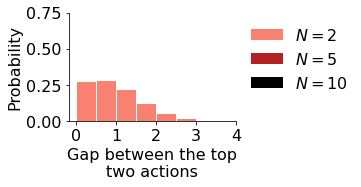

In [21]:
# Plot the distribution of gaps
bin_centers = 0.5*(bins0[1:] + bins0[:-1])
bin_widths = np.diff(bins0)

fig, ax = plt.subplots(figsize=(3,2))
legend_elements = [Patch(facecolor='salmon', label='$N=2$'), 
                   Patch(facecolor='firebrick', label='$N=5$'),
                  Patch(facecolor='black', label='$N=10$')]
ax.legend(handles=legend_elements, frameon = False, bbox_to_anchor=(1,1), loc='upper left')

ax.bar(bin_centers, heights0, width=bin_widths, edgecolor='white', color='salmon')
ax.set_xlabel('Gap between the top\ntwo actions')
ax.set_ylabel('Probability')
ax.set_ylim(0,0.75)
# ax.set_xlim(-0.2,4)
ax.set_xticks(np.arange(0, 4.1, 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('3B_left.png', format='png', dpi=1000,bbox_inches = 'tight')

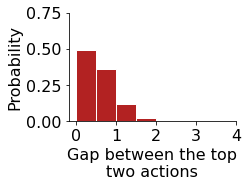

In [22]:
# Plot the distribution of gaps
bin_centers = 0.5*(bins5[1:] + bins5[:-1])
bin_widths = np.diff(bins5)

fig, ax = plt.subplots(figsize=(3,2))
ax.bar(bin_centers, heights5, width=bin_widths, edgecolor='white', color='firebrick')
ax.set_xlabel('Gap between the top\ntwo actions')
ax.set_ylabel('Probability')
ax.set_ylim(0,0.75)
# ax.set_xlim(-0.2,4)
ax.set_xticks(np.arange(0, 4.1, 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('3B_middle.png', format='png', dpi=1000,bbox_inches = 'tight')

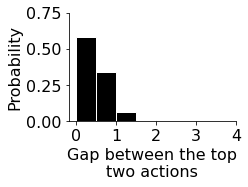

In [23]:
# Plot the distribution of gaps
bin_centers = 0.5*(bins10[1:] + bins10[:-1])
bin_widths = np.diff(bins10)

fig, ax = plt.subplots(figsize=(3,2))
ax.bar(bin_centers, heights10, width=bin_widths, edgecolor='white', color='black')
ax.set_xlabel('Gap between the top\ntwo actions')
ax.set_ylabel('Probability')
ax.set_ylim(0,0.75)
# ax.set_xlim(-0.2,4)
ax.set_xticks(np.arange(0, 4.1, 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('3B_right.png', format='png', dpi=1000,bbox_inches = 'tight')

In [24]:
# Helper function to map numbers to the nearest divisor
def round_down(num, divisor):
    return num - (num%divisor)

# Redefine parameters
num_actions = np.arange(2, 21, 1)
num_sims = 10000
T_steps = 21
T_all = np.arange(1, T_steps, 1)

# Set the range of gaps
gap_range = np.arange(0,8.5,0.125)

# Compute net value for a single cost
cost = .1
gap_action_final = np.zeros((len(gap_range),len(num_actions)))
gap_action_weights = np.zeros((len(gap_range),len(num_actions)))

# Loop through the gap ranges
for ii in range(num_sims):
    for jj in range(len(num_actions)):
        for T in T_all: 
            curr_gap = gap_dist[T-1, ii, jj]
            curr_value = M_T_max_actions[T-1,ii,jj]-cost
            gap_ind = np.where(gap_range == round_down(curr_gap,.125))[0][0]
            if curr_value > 0:
                gap_action_final[gap_ind, jj] += 1
            gap_action_weights[gap_ind, jj] += 1    

In [25]:
# Compute the average array to plot
gap_action_avg = np.divide(gap_action_final, gap_action_weights, out=np.zeros_like(gap_action_final), where=gap_action_weights!=0)

# Normalize the weights to be between 0 and 1 for alpha
gap_action_weights_norm = (gap_action_weights - np.min(gap_action_weights))/np.ptp(gap_action_weights)

(-0.5, 11.5)

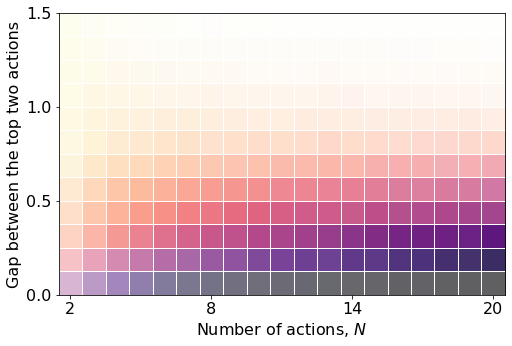

In [26]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
cmap = plt.get_cmap('magma_r')
im = plt.imshow(gap_action_avg[0:12], cmap=cmap, alpha=gap_action_weights_norm[0:12])

# Axis labels
ax.set_xticks(np.arange(0,len(num_actions)+1,6))
ax.set_yticks(np.arange(-0.5,12.5,4))
ax.set_xticklabels(np.arange(num_actions[0],num_actions[-1]+1,6))
ax.set_yticklabels(np.arange(gap_range[0],1.5+0.25,0.5))
ax.set_xlabel('Number of actions, $N$')
ax.set_ylabel('Gap between the top two actions')

# Create gridlines
ax.set_xticks(np.arange(len(num_actions)+1)-.5, minor=True)
ax.set_yticks(np.arange(12+1)-.5, minor=True)
ax.grid(which='major',color="w", axis='y',linestyle='-', linewidth=1 )
ax.grid(which='minor',color="w", linestyle='-', linewidth=1 )
ax.tick_params(which="minor", bottom=False, left=False)

# Flip the y axis
ax.set_ylim(ax.get_ylim()[::-1])
    
# plt.savefig('S1B.png', format='png', dpi=1000,bbox_inches = 'tight')

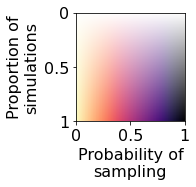

In [101]:
# Create the colorbar here
# plt.rcParams.update({'font.size': 42})

a = np.linspace(2,20,1000)
b = np.linspace(0,1,1000)
x = np.repeat(a,1000).reshape(1000,1000)
y =  np.repeat(b,1000).reshape(1000,1000)

fig, ax = plt.subplots(figsize=(2,2))
# cmap = plt.get_cmap('autumn')
im = plt.imshow(x.T, cmap=cmap, alpha=y, interpolation='bilinear')

ax.set_xticks(np.arange(0,1200,500)-.5)
ax.set_xticklabels([0,0.5,1])
ax.set_yticks(np.arange(0,1200,500)-.5)
ax.set_yticklabels([0,0.5,1])

ax.set_xlabel('Probability of\nsampling')
ax.set_ylabel('Proportion of\nsimulations')

# plt.savefig('S1B_colorbar.png', format='png', dpi=1000,bbox_inches = 'tight')

In [27]:
# Compute net value for a single cost
cost = .1
gap_prosp_final2 = np.zeros((len(gap_range),len(T_all)))
gap_prosp_weights2 = np.zeros((len(gap_range),len(T_all)))

# Loop through the gap ranges
jj = 0
for ii in range(num_sims):
    for T in T_all: 
        curr_gap = gap_dist[T-1, ii, jj]
        curr_value = M_T_max_actions[T-1,ii,jj]-cost
        gap_ind = np.where(gap_range == round_down(curr_gap,.125))[0][0]
        if curr_value > 0:
            gap_prosp_final2[gap_ind, T-1] += 1
        gap_prosp_weights2[gap_ind, T-1] += 1  
        
gap_prosp_avg2 = np.divide(gap_prosp_final2, gap_prosp_weights2, out=np.zeros_like(gap_prosp_final2), where=gap_prosp_weights2!=0)

In [30]:
a = np.average(gap_prosp_avg2[0:4,:],axis=0)
b = np.average(gap_prosp_avg2[4:8,:],axis=0)
c = np.average(gap_prosp_avg2[8:12,:],axis=0)

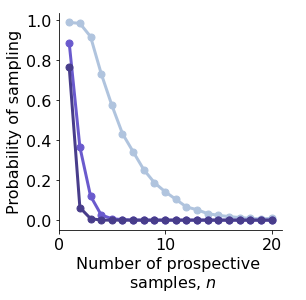

In [59]:
fig, ax = plt.subplots(figsize=(4,4))
# legend_elements = [Line2D([0], [0], marker='o', ms=7, color='salmon', lw=2, label='low gaps'),  Line2D([0], [0], marker='o', ms=7, color='red', lw=2, label='high gaps')]
# ax.legend(handles=legend_elements, frameon = False, loc='upper right')
ax.plot(T_all, a, marker='o', ms=7, color = 'lightsteelblue', lw=3)
ax.plot(T_all, b, marker='o', ms=7, color = 'slateblue', lw=3)
ax.plot(T_all, c, marker='o', ms=7, color = 'darkslateblue', lw=3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,10,20])
ax.set_yticks([0,.2,.4,.6,.8,1])

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.set_xlabel('Number of prospective \n samples, $\it{n}$')
plt.ylabel('Probability of sampling')

# ax.legend(frameon = False, loc='upper right')

# plt.savefig('3C_left.png', format='png', dpi=1000,bbox_inches = 'tight')

In [39]:
# Compute net value for a single cost
cost = .1
gap_prosp_final5 = np.zeros((len(gap_range),len(T_all)))
gap_prosp_weights5 = np.zeros((len(gap_range),len(T_all)))

# Loop through the gap ranges
jj = 3
for ii in range(num_sims):
    for T in T_all: 
        curr_gap = gap_dist[T-1, ii, jj]
        curr_value = M_T_max_actions[T-1,ii,jj]-cost
        gap_ind = np.where(gap_range == round_down(curr_gap,.125))[0][0]
        if curr_value > 0:
            gap_prosp_final5[gap_ind, T-1] += 1
        gap_prosp_weights5[gap_ind, T-1] += 1  
        
gap_prosp_avg5 = np.divide(gap_prosp_final5, gap_prosp_weights5, out=np.zeros_like(gap_prosp_final5), where=gap_prosp_weights5!=0)

In [40]:
g = np.average(gap_prosp_avg5[0:4,:],axis=0)
h = np.average(gap_prosp_avg5[4:8,:],axis=0)
i = np.average(gap_prosp_avg5[8:12,:],axis=0)

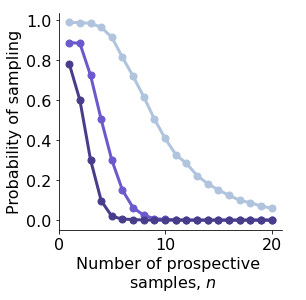

In [58]:
fig, ax = plt.subplots(figsize=(4,4))
# legend_elements = [Line2D([0], [0], marker='o', ms=7, color='firebrick', lw=2, label='low gaps'),  Line2D([0], [0], marker='o', ms=7, color='black', lw=2, label='high gaps')]
# ax.legend(handles=legend_elements, frameon = False, bbox_to_anchor=(1,1), loc='upper left')
ax.plot(T_all, g, marker='o', ms=7, color = 'lightsteelblue', lw=3)
ax.plot(T_all, h, marker='o', ms=7, color = 'slateblue', lw=3)
ax.plot(T_all, i, marker='o', ms=7, color = 'darkslateblue', lw=3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,10,20])
ax.set_yticks([0,.2,.4,.6,.8,1])

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.set_xlabel('Number of prospective \n samples, $\it{n}$')
plt.ylabel('Probability of sampling')

# ax.legend(frameon = False, loc='upper right')

# plt.savefig('3C_middle.png', format='png', dpi=1000,bbox_inches = 'tight')

In [34]:
# Compute net value for a single cost
cost = .1
gap_prosp_final10 = np.zeros((len(gap_range),len(T_all)))
gap_prosp_weights10 = np.zeros((len(gap_range),len(T_all)))

# Loop through the gap ranges
jj = 8
for ii in range(num_sims):
    for T in T_all: 
        curr_gap = gap_dist[T-1, ii, jj]
        curr_value = M_T_max_actions[T-1,ii,jj]-cost
        gap_ind = np.where(gap_range == round_down(curr_gap,.125))[0][0]
        if curr_value > 0:
            gap_prosp_final10[gap_ind, T-1] += 1
        gap_prosp_weights10[gap_ind, T-1] += 1  
        
gap_prosp_avg10 = np.divide(gap_prosp_final10, gap_prosp_weights10, out=np.zeros_like(gap_prosp_final10), where=gap_prosp_weights10!=0)

In [37]:
d = np.average(gap_prosp_avg10[0:4,:],axis=0)
e = np.average(gap_prosp_avg10[4:8,:],axis=0)
f = np.average(gap_prosp_avg10[8:12,:],axis=0)

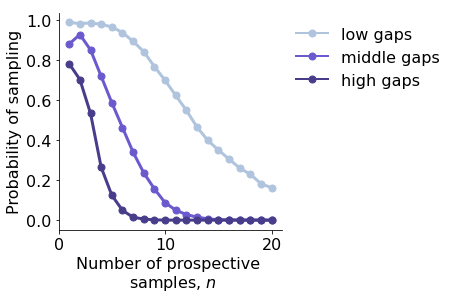

In [56]:
fig, ax = plt.subplots(figsize=(4,4))
legend_elements = [Line2D([0], [0], marker='o', ms=7, color='lightsteelblue', lw=2, label='low gaps'),  Line2D([0], [0], marker='o', ms=7, color='slateblue', lw=2, label='middle gaps'), Line2D([0], [0], marker='o', ms=7, color='darkslateblue', lw=2, label='high gaps')]
ax.legend(handles=legend_elements, frameon = False, bbox_to_anchor=(1,1), loc='upper left')
ax.plot(T_all, d, marker='o', ms=7, color = 'lightsteelblue', lw=3)
ax.plot(T_all, e, marker='o', ms=7, color = 'slateblue', lw=3)
ax.plot(T_all, f, marker='o', ms=7, color = 'darkslateblue', lw=3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,10,20])
ax.set_yticks([0,.2,.4,.6,.8,1])

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.set_xlabel('Number of prospective \n samples, $\it{n}$')
plt.ylabel('Probability of sampling')

# ax.legend(frameon = False, loc='upper right')

# plt.savefig('3C_right.png', format='png', dpi=1000,bbox_inches = 'tight')

## Retrospective simulations

In [27]:
# Set parameters
num_actions = 5
sigma_0 = 1
sigma_retro = 10
sigma = 1
v_samples = 1000              # number of linearly spaced samples for the analytical max distribution

T_steps = 11
T_all = np.arange(1, T_steps, 1)  # number of total time steps to run

# Set the Poisson rates
num_sims = 1000
Poisson_rates = np.arange(0, 16, 3)
M_T_Poisson_sims5 = np.zeros((T_steps-1, num_sims, len(Poisson_rates)))

for i in range(num_sims):
    for j in range(len(Poisson_rates)):
    
        var_running = np.ones(num_actions)*(sigma**2)

        # Run the generative model
        qbar_retro_all, q_1_all, n_samples_all, prior = gen_model_init(num_actions, sigma_0, sigma_retro, sigma, Poisson_rates[j], no_retro = False)

        # Array to store value of state based on action that is sampled
        M_T_curr = np.ones(num_actions)
        M_T_max = np.zeros(T_steps-1)

        # Array to store time steps and sigmas
        T_action = np.ones(num_actions)

        # Compute useful values ahead of time
        J_0 = 1/sigma_0**2
        J_retro = 1/sigma_retro**2
        J = 1/sigma**2

        for T in T_all:

            # Compute J_a, mu, and sigma^2
            if T == 1:
                J_T = J_0 + J_retro*n_samples_all + J*T_action
                mu_T = (qbar_retro_all*J_retro*n_samples_all + q_1_all*J*T_action)/J_T
                var_running = 1/J_T
            else:
                J_T = 1/var_running

            # Loop through each action to consider sampling it
            for n in range(num_actions):
                mu_Tplus1, var_Tplus1, max_dist_Tplus1, M_Tplus1 = inference_action(mu_T, n, num_actions, J, J_T, v_samples)
                M_T_curr[n] = M_Tplus1

            # Max gain action
            max_prev = np.max(mu_T)
            gain_value = M_T_curr-max_prev
            max_value = np.max(gain_value)
            max_ind = np.argmax(gain_value)
            M_T_max[T-1] = max_value

            # Update the prospective value of the max gain action
            new_myopic = np.random.normal(prior[max_ind], sigma)

            # Update the posterior mean and variance with the new sample
            post_mean = ((mu_T[max_ind]*J_T[max_ind])+(J*new_myopic))/(J_T[max_ind]+J) 
            post_var = 1/(J_T[max_ind]+J)

            mu_T[max_ind] = post_mean
            var_running[max_ind] = post_var

            # Update the counter for the action that was chosen
            T_action[max_ind] += 1

        # Save the overall values
        M_T_Poisson_sims5[:,i,j] = M_T_max

/Users/ionatankuperwajs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


In [61]:
with open('saved_analyses_online/M_T_Poisson_sims2.pickle', 'wb') as handle:
    pickle.dump(M_T_Poisson_sims2, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('saved_analyses_online/M_T_Poisson_sims10.pickle', 'wb') as handle:
    pickle.dump(M_T_Poisson_sims10, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
with open('saved_analyses_online/M_T_Poisson_sims2.pickle', 'rb') as handle:
    M_T_Poisson_sims2 = pickle.load(handle)
    
with open('saved_analyses_online/M_T_Poisson_sims10.pickle', 'rb') as handle:
    M_T_Poisson_sims10 = pickle.load(handle)

In [69]:
# Set some parameters
T_steps = 11
T_all = np.arange(1, T_steps, 1)
num_sims = 1000
Poisson_rates = np.arange(0, 16, 3)

# Compute net value for a few different costs
cost = 0.1
M_T_Poisson_total = np.zeros((num_sims,len(Poisson_rates)))
M_T_Poisson_count = np.zeros((num_sims,len(Poisson_rates)))

# Loop through the simulations and compute whether it is worthwhile to expand
for i in range(num_sims):
    for j in range(len(Poisson_rates)):
        for T in T_all:
            curr_value = M_T_Poisson_sims10[T-1,i,j]-cost
            if curr_value > 0:
                M_T_Poisson_total[i, j] += 1
            M_T_Poisson_count[i, j] += 1

Poisson_cost_avg10 = np.average(M_T_Poisson_total/M_T_Poisson_count,axis=0)

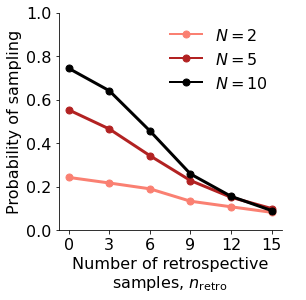

In [73]:
fig, ax = plt.subplots(figsize=(4,4))
legend_elements = [Line2D([0], [0], marker='o', ms=7, color='salmon', lw=2, label='$N=2$'),  Line2D([0], [0], marker='o', ms=7, color='firebrick', lw=2, label='$N=5$'), Line2D([0], [0], marker='o', ms=7, color='black', lw=2, label='$N=10$')]
ax.legend(handles=legend_elements, frameon = False, loc='upper right')
ax.plot(Poisson_rates, Poisson_cost_avg2, marker='o', ms=7, color = 'salmon', lw=3)
ax.plot(Poisson_rates, Poisson_cost_avg5, marker='o', ms=7, color = 'firebrick', lw=3)
ax.plot(Poisson_rates, Poisson_cost_avg10, marker='o', ms=7, color = 'black', lw=3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0, 16, 3))
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Number of retrospective\nsamples, $n_{\mathrm{retro}}$')
plt.ylabel('Probability of sampling')

# ax.legend(frameon = False, loc='upper right')

# plt.savefig('3D.png', format='png', dpi=1000,bbox_inches = 'tight')

In [34]:
# Set some parameters
T_steps = 11
T_all = np.arange(1, T_steps, 1)
num_sims = 1000
Poisson_rates = np.arange(0, 16, 3)

# Compute net value for a few different costs
cost = 0.1
M_T_Poisson_total = np.zeros((num_sims,len(Poisson_rates),len(T_all)))
M_T_Poisson_count = np.zeros((num_sims,len(Poisson_rates),len(T_all)))

# Loop through the simulations and compute whether it is worthwhile to expand
for i in range(num_sims):
    for j in range(len(Poisson_rates)):
        for T in T_all:
            curr_value = M_T_Poisson_sims5[T-1,i,j]-cost
            if curr_value > 0:
                M_T_Poisson_total[i, j, T-1] += 1
            M_T_Poisson_count[i, j, T-1] += 1

Poisson_cost_avg5 = np.average(M_T_Poisson_total/M_T_Poisson_count,axis=0)

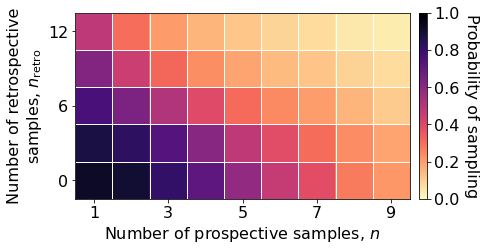

In [44]:
plt.rcParams["figure.figsize"] = (6,4)

fig, ax = plt.subplots()

cmap = plt.get_cmap('magma_r')
im = ax.imshow(Poisson_cost_avg5[0:5,0:9], cmap=cmap, vmin=0, vmax=1)

# Create colorbar
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
colorbar = plt.colorbar(im, cax=cax)
colorbar.ax.set_ylabel('Probability of sampling', rotation=-90, va="bottom")
# colorbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

# Axis labels
ax.set_yticks(np.arange(0,len(Poisson_rates),2))
ax.set_xticks(np.arange(0,len(T_all),2))
ax.set_xticklabels(np.arange(1,11,2).astype(int))
ax.set_yticklabels(np.arange(0,16,6).astype(int))
ax.set_xlabel('Number of prospective samples, $n$')
ax.set_ylabel('Number of retrospective\nsamples, $n_\mathrm{retro}$')

# # Create gridlines
ax.set_xticks(np.arange(len(T_all))-.5, minor=True)
ax.set_yticks(np.arange(len(Poisson_rates))-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)

# Flip the y axis
ax.set_ylim(ax.get_ylim()[::-1])   
    
# plt.savefig('S1C.png', format='png', dpi=1000,bbox_inches = 'tight')


In [102]:
# Set parameters
num_actions = 5
sigma_0 = 1
sigma_retro = np.arange(0, 4.25, 0.5)
sigma = np.arange(0, 4.25, 0.5)
v_samples = 1000              # number of linearly spaced samples for the analytical max distribution

T_steps = 11
T_all = np.arange(1, T_steps, 1)  # number of total time steps to run

# Set the Poisson rates
num_sims = 1000
M_T_sigma_sims = np.zeros((T_steps-1, num_sims, len(sigma_retro), len(sigma)))

for i in range(num_sims):
    for j in range(len(sigma_retro)):
        for z in range(len(sigma)):
    
            var_running = np.ones(num_actions)*(sigma[z]**2)

            # Run the generative model
            qbar_retro_all, q_1_all, n_samples_all, prior = gen_model_init(num_actions, sigma_0, sigma_retro[j], sigma[z], no_retro = False)

            # Array to store value of state based on action that is sampled
            M_T_curr = np.ones(num_actions)
            M_T_max = np.zeros(T_steps-1)

            # Array to store time steps and sigmas
            T_action = np.ones(num_actions)

            # Compute useful values ahead of time
            J_0 = 1/sigma_0**2
            J_retro = 1/sigma_retro[j]**2
            J = 1/sigma[z]**2

            for T in T_all:

                # Compute J_a, mu, and sigma^2
                if T == 1:
                    J_T = J_0 + J_retro*n_samples_all + J*T_action
                    mu_T = (qbar_retro_all*J_retro*n_samples_all + q_1_all*J*T_action)/J_T
                    var_running = 1/J_T
                else:
                    J_T = 1/var_running

                # Loop through each action to consider sampling it
                for n in range(num_actions):
                    mu_Tplus1, var_Tplus1, max_dist_Tplus1, M_Tplus1 = inference_action(mu_T, n, num_actions, J, J_T, v_samples)
                    M_T_curr[n] = M_Tplus1

                # Max gain action
                max_prev = np.max(mu_T)
                gain_value = M_T_curr-max_prev
                max_value = np.max(gain_value)
                max_ind = np.argmax(gain_value)
                M_T_max[T-1] = max_value

                # Update the prospective value of the max gain action
                new_myopic = np.random.normal(prior[max_ind], sigma[z])

                # Update the posterior mean and variance with the new sample
                post_mean = ((mu_T[max_ind]*J_T[max_ind])+(J*new_myopic))/(J_T[max_ind]+J) 
                post_var = 1/(J_T[max_ind]+J)

                mu_T[max_ind] = post_mean
                var_running[max_ind] = post_var

                # Update the counter for the action that was chosen
                T_action[max_ind] += 1

            # Save the overall values
            M_T_sigma_sims[:,i,j,z] = M_T_max

/Users/ionatankuperwajs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars
/Users/ionatankuperwajs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars
/Users/ionatankuperwajs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in multiply
/Users/ionatankuperwajs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in multiply
/Users/ionatankuperwajs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/Users/ionatankuperwajs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/Users/ionatankuperwajs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarnin

In [103]:
with open('saved_analyses_online/M_T_sigma_sims.pickle', 'wb') as handle:
    pickle.dump(M_T_sigma_sims, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('saved_analyses_online/M_T_sigma_sims.pickle', 'rb') as handle:
    M_T_sigma_sims = pickle.load(handle)

In [104]:
# Compute net value for a few different costs
cost = 0.05
M_T_sigma_total = np.zeros((num_sims, len(sigma_retro),len(sigma)))
M_T_sigma_count = np.zeros((num_sims, len(sigma_retro),len(sigma)))

# Loop through the simulations and compute whether it is worthwhile to expand
for i in range(num_sims):
    for j in range(len(sigma_retro)):
        for z in range(len(sigma)):
            for T in T_all:
                curr_value = M_T_sigma_sims[T-1,i,j,z]-cost
                if curr_value > 0:
                    M_T_sigma_total[i, j, z] += 1
                M_T_sigma_count[i, j, z] += 1

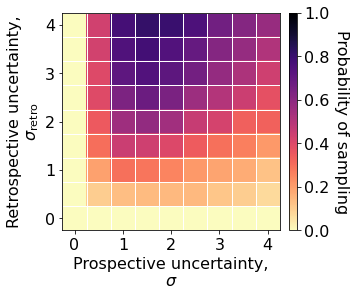

In [107]:
plt.rcParams["figure.figsize"] = (6,4)

fig, ax = plt.subplots()

cmap = plt.get_cmap('magma_r')
im = ax.imshow(np.average(M_T_sigma_total,axis=0)/np.average(M_T_sigma_count,axis=0), cmap=cmap, vmin=0, vmax=1)

# Create colorbar
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
colorbar = plt.colorbar(im, cax=cax)
colorbar.ax.set_ylabel('Probability of sampling', rotation=-90, va="bottom")
# colorbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

# Axis labels
ax.set_xticks(np.arange(0,len(sigma_retro),2))
ax.set_yticks(np.arange(0,len(sigma),2))
ax.set_xticklabels(np.arange(0,4.1,1).astype(int))
ax.set_yticklabels(np.arange(0,4.1,1).astype(int))
ax.set_xlabel('Prospective uncertainty,\n$\sigma$')
ax.set_ylabel('Retrospective uncertainty,\n$\sigma_{\mathrm{retro}}$')

# # Create gridlines
ax.set_xticks(np.arange(len(sigma_retro)+1)-.5, minor=True)
ax.set_yticks(np.arange(len(sigma)+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)

# Flip the y axis
ax.set_ylim(ax.get_ylim()[::-1])   
    
# plt.savefig('3E.png', format='png', dpi=1000,bbox_inches = 'tight')

## Comparison to other search algorithms

In [13]:
# Set parameters
num_actions = 5
sigma_0 = 1
sigma_retro = 10
sigma = 1
v_samples = 1000              # number of linearly spaced samples for the analytical max distribution
num_sims = 1000

T_steps = 51
T_all = np.arange(1, T_steps, 1)  # number of total time steps to run

M_T_max_model = np.zeros((T_steps-1, num_sims))
M_T_max_bfs = np.zeros((T_steps-1, num_sims))

for i in range(num_sims):
    
    var_running = np.ones(num_actions)*(sigma**2)
    
    # Run the generative model
    qbar_retro_all, q_1_all, n_samples_all, prior = gen_model_init(num_actions, sigma_0, sigma_retro, sigma, no_retro = True)
    
    # Array to store value of state based on action that is sampled
    M_T_curr = np.ones(num_actions)
    M_T_model = np.zeros(T_steps-1)
    M_T_bfs = np.zeros(T_steps-1)

    # Array to store time steps and sigmas
    T_action = np.ones(num_actions)
    
    # Compute useful values ahead of time
    J_0 = 1/sigma_0**2
    J_retro = 1/sigma_retro**2
    J = 1/sigma**2
     
    for T in T_all:
        
        # Compute J_a, mu, and sigma^2
        if T == 1:
            J_T = J_0 + J_retro*n_samples_all + J*T_action
            mu_T = (qbar_retro_all*J_retro*n_samples_all + q_1_all*J*T_action)/J_T
            var_running = 1/J_T
        else:
            J_T = 1/var_running
                
        # Loop through each action to consider sampling it
        for n in range(num_actions):
            mu_Tplus1, var_Tplus1, max_dist_Tplus1, M_Tplus1 = inference_action(mu_T, n, num_actions, J, J_T, v_samples)
            M_T_curr[n] = M_Tplus1
        
        # Max gain action
        max_prev = np.max(mu_T)
        gain_value = M_T_curr-max_prev
        max_value = np.max(gain_value)
        max_ind = np.argmax(gain_value)
        M_T_model[T-1] = max_value
        M_T_bfs[T-1] = gain_value[np.argmax(mu_T)]
        
        # Update the prospective value of the max gain action
        new_myopic = np.random.normal(prior[max_ind], sigma)
        
        # Update the posterior mean and variance with the new sample
        post_mean = ((mu_T[max_ind]*J_T[max_ind])+(J*new_myopic))/(J_T[max_ind]+J) 
        post_var = 1/(J_T[max_ind]+J)

        mu_T[max_ind] = post_mean
        var_running[max_ind] = post_var
        
        # Update the counter for the action that was chosen
        T_action[max_ind] += 1
    
    # Save the overall values
    M_T_max_model[:,i] = M_T_model
    M_T_max_bfs[:,i] = M_T_bfs

In [14]:
utility_model = np.average(M_T_max_model,axis=1)
utility_bfs = np.average(M_T_max_bfs,axis=1)

In [15]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Greys')
new_cmap = truncate_colormap(cmap, 0.3, 1.0)

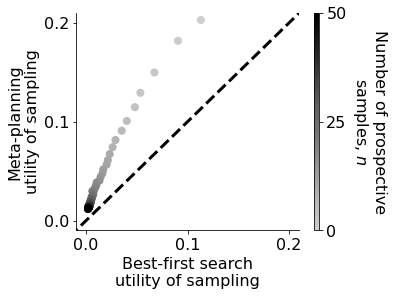

In [25]:
fig, ax = plt.subplots(figsize=(4,4))
cmap=plt.cm.get_cmap('Greys')
ax.scatter(utility_bfs, utility_model, marker='o', s=50, c=T_all,cmap=new_cmap)

x = np.linspace(-0.05,0.5,100)
y = x
plt.plot(x, y, color='black',linewidth=3,linestyle='--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(-0.01,0.21)
ax.set_ylim(-0.01,0.21)
ax.set_xticks(np.arange(0, 0.21, 0.1))
ax.set_yticks(np.arange(0, 0.21, 0.1))
plt.ylabel('Meta-planning\nutility of sampling')
plt.xlabel('Best-first search\nutility of sampling')

# Create colorbar

cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
cb = plt.colorbar(mpl.cm.ScalarMappable(cmap=new_cmap), cax=cax, orientation='vertical')
cb.set_ticks([0,0.5,1.0])
cb.set_ticklabels([0,25,50])
cb.set_label('Number of prospective\nsamples, $n$',rotation=-90, va="bottom")

# plt.savefig('4C.png', format='png', dpi=1000,bbox_inches = 'tight')

In [301]:
# Set parameters
num_actions = 5
sigma_0 = 1
sigma_retro = 10
sigma = 1
v_samples = 1000              # number of linearly spaced samples for the analytical max distribution
num_sims = 10000

T_steps = 51
T_all = np.arange(1, T_steps, 1)  # number of total time steps to run

M_T_seq_model = np.zeros((T_steps-1, num_sims))
M_T_seq_bfs = np.zeros((T_steps-1, num_sims))
M_T_seq_model_prev = np.zeros((T_steps-1, num_sims))
M_T_seq_bfs_prev = np.zeros((T_steps-1, num_sims))
M_T_seq_breadth = np.zeros((T_steps-1, num_sims))
M_T_seq_breadth_prev = np.zeros((T_steps-1, num_sims))

for i in range(num_sims):
    
    var_running = np.ones(num_actions)*(sigma**2)
    var_running_bfs = np.ones(num_actions)*(sigma**2)
    var_running_breadth = np.ones(num_actions)*(sigma**2)
    
    # Run the generative model
    qbar_retro_all, q_1_all, n_samples_all, prior = gen_model_init(num_actions, sigma_0, sigma_retro, sigma, no_retro = True)
    
    # Array to store value of state based on action that is sampled
    M_T_curr = np.ones(num_actions)
    M_T_curr_bfs = np.ones(num_actions)
    M_T_curr_breadth = np.ones(num_actions)
    
    M_T_model = np.zeros(T_steps-1)
    M_T_model_prev = np.zeros(T_steps-1)
    M_T_bfs = np.zeros(T_steps-1)
    M_T_bfs_prev = np.zeros(T_steps-1)
    M_T_breadth = np.zeros(T_steps-1)
    M_T_breadth_prev = np.zeros(T_steps-1)

    # Array to store time steps and sigmas
    T_action = np.ones(num_actions)
    T_action_bfs = np.ones(num_actions)
    T_action_breadth = np.ones(num_actions)
    
    # Compute useful values ahead of time
    J_0 = 1/sigma_0**2
    J_retro = 1/sigma_retro**2
    J = 1/sigma**2
    
    for T in T_all:
        
        # Compute J_a, mu, and sigma^2
        if T == 1:
            J_T = J_0 + J_retro*n_samples_all + J*T_action
            mu_T = (qbar_retro_all*J_retro*n_samples_all + q_1_all*J*T_action)/J_T
            var_running = 1/J_T
            
            J_T_bfs = J_0 + J_retro*n_samples_all + J*T_action_bfs
            mu_T_bfs = np.copy(mu_T)
            var_running_bfs = 1/J_T
            
            J_T_breadth = J_0 + J_retro*n_samples_all + J*T_action_breadth
            mu_T_breadth = np.copy(mu_T)
            var_running_breadth = 1/J_T
            breadth_count = 0
        else:
            J_T = 1/var_running

            J_T_bfs = 1/var_running_bfs
            J_T_breadth = 1/var_running_breadth
            
            if breadth_count == 4:
                breadth_count = 0
            else:
                breadth_count += 1
                
        # Loop through each action to consider sampling it
        for n in range(num_actions):
            mu_Tplus1, var_Tplus1, max_dist_Tplus1, M_Tplus1 = inference_action(mu_T, n, num_actions, J, J_T, v_samples)
            M_T_curr[n] = M_Tplus1
            
            mu_Tplus1_bfs, var_Tplus1_bfs, max_dist_Tplus1_bfs, M_Tplus1_bfs = inference_action(mu_T_bfs, n, num_actions, J, J_T_bfs, v_samples)
            M_T_curr_bfs[n] = M_Tplus1_bfs
            
            mu_Tplus1_breadth, var_Tplus1_breadth, max_dist_Tplus1_breadth, M_Tplus1_breadth = inference_action(mu_T_breadth, n, num_actions, J, J_T_breadth, v_samples)
            M_T_curr_breadth[n] = M_Tplus1_breadth
        
        # Max gain action
        max_prev = np.max(mu_T)
        gain_value = M_T_curr-max_prev
        max_value = np.max(gain_value)
        max_ind = np.argmax(gain_value)
        M_T_model[T-1] = max_value
        M_T_model_prev[T-1] = max_prev
        
        # BFS action
        max_prev_bfs = np.max(mu_T_bfs)
        gain_value_bfs = M_T_curr_bfs - max_prev_bfs
        max_ind_bfs = np.argmax(mu_T_bfs)
        M_T_bfs[T-1] = gain_value_bfs[max_ind_bfs]
        M_T_bfs_prev[T-1] = max_prev_bfs
        
        # Breadth action
        max_prev_breadth = np.max(mu_T_breadth)
        gain_value_breadth = M_T_curr_breadth - max_prev_breadth
        max_ind_breadth = breadth_count
        M_T_breadth[T-1] = gain_value_breadth[max_ind_breadth]
        M_T_breadth_prev[T-1] = max_prev_breadth
        
        # Update the prospective value of the max gain action
        new_myopic = np.random.normal(prior[max_ind], sigma)
        new_myopic_bfs = np.random.normal(prior[max_ind_bfs], sigma)
        new_myopic_breadth = np.random.normal(prior[max_ind_breadth], sigma)
        
        # Update the posterior mean and variance with the new sample
        post_mean = ((mu_T[max_ind]*J_T[max_ind])+(J*new_myopic))/(J_T[max_ind]+J) 
        post_var = 1/(J_T[max_ind]+J)
        mu_T[max_ind] = post_mean
        var_running[max_ind] = post_var
        
        post_mean_bfs = ((mu_T_bfs[max_ind_bfs]*J_T_bfs[max_ind_bfs])+(J*new_myopic_bfs))/(J_T_bfs[max_ind_bfs]+J) 
        post_var_bfs = 1/(J_T_bfs[max_ind_bfs]+J)
        mu_T_bfs[max_ind_bfs] = post_mean_bfs
        var_running_bfs[max_ind_bfs] = post_var_bfs
        
        post_mean_breadth = ((mu_T_breadth[max_ind_breadth]*J_T_breadth[max_ind_breadth])+(J*new_myopic_breadth))/(J_T_breadth[max_ind_breadth]+J) 
        post_var_breadth = 1/(J_T_breadth[max_ind_breadth]+J)
        mu_T_breadth[max_ind_breadth] = post_mean_breadth
        var_running_breadth[max_ind_breadth] = post_var_breadth
        
        # Update the counter for the action that was chosen
        T_action[max_ind] += 1
        T_action_bfs[max_ind_bfs] += 1
        T_action_breadth[max_ind_breadth] += 1
    
    # Save the overall values
    M_T_seq_model[:,i] = M_T_model
    M_T_seq_bfs[:,i] = M_T_bfs
    M_T_seq_model_prev[:,i] = M_T_model_prev
    M_T_seq_bfs_prev[:,i] = M_T_bfs_prev
    M_T_seq_breadth[:,i] = M_T_breadth
    M_T_seq_breadth_prev[:,i] = M_T_breadth_prev

In [337]:
with open('saved_analyses_online/M_T_seq_model_prev.pickle', 'wb') as handle:
    pickle.dump(M_T_seq_model_prev, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('saved_analyses_online/M_T_seq_bfs_prev.pickle', 'wb') as handle:
    pickle.dump(M_T_seq_bfs_prev, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('saved_analyses_online/M_T_seq_breadth_prev.pickle', 'wb') as handle:
    pickle.dump(M_T_seq_breadth_prev, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('saved_analyses_online/M_T_seq_model.pickle', 'wb') as handle:
    pickle.dump(M_T_seq_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('saved_analyses_online/M_T_seq_bfs.pickle', 'wb') as handle:
    pickle.dump(M_T_seq_bfs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('saved_analyses_online/M_T_seq_breadth.pickle', 'wb') as handle:
    pickle.dump(M_T_seq_breadth, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
with open('saved_analyses_online/M_T_seq_model_prev.pickle', 'rb') as handle:
    M_T_seq_model_prev = pickle.load(handle)
    
with open('saved_analyses_online/M_T_seq_bfs_prev.pickle', 'rb') as handle:
    M_T_seq_bfs_prev = pickle.load(handle)
    
with open('saved_analyses_online/M_T_seq_breadth_prev.pickle', 'rb') as handle:
    M_T_seq_breadth_prev = pickle.load(handle)
    
with open('saved_analyses_online/M_T_seq_model.pickle', 'rb') as handle:
    M_T_seq_model = pickle.load(handle)
    
with open('saved_analyses_online/M_T_seq_bfs.pickle', 'rb') as handle:
    M_T_seq_bfs = pickle.load(handle)
    
with open('saved_analyses_online/M_T_seq_breadth.pickle', 'rb') as handle:
    M_T_seq_breadth = pickle.load(handle)

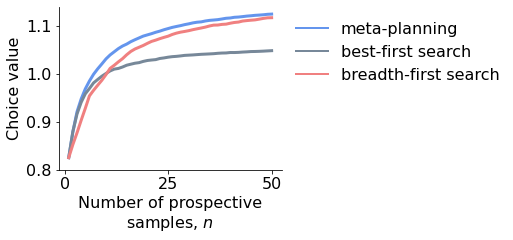

In [100]:
# Plot
fig, ax = plt.subplots(figsize=(4,3))
legend_elements = [Line2D([0], [0], color='cornflowerblue', lw=2, label='meta-planning'),
                   Line2D([0], [0], color='lightslategray', lw=2, label='best-first search'),
                  Line2D([0], [0], color='lightcoral', lw=2, label='breadth-first search')]
ax.legend(handles=legend_elements, frameon = False, bbox_to_anchor=(1,1), loc='upper left')

ax.plot(np.arange(1,51,1),np.average(M_T_seq_model_prev,axis=1), color = 'cornflowerblue', lw=3)
ax.plot(np.arange(1,51,1),np.average(M_T_seq_bfs_prev,axis=1), color = 'lightslategray', lw=3)
ax.plot(np.arange(1,51,1),np.average(M_T_seq_breadth_prev,axis=1), color = 'lightcoral', lw=3)

ax.set_xticks([0,25,50])
ax.set_yticks([0.8, 0.9, 1.0, 1.1])
ax.set_xlabel('Number of prospective\nsamples, $\it{n}$')
ax.set_ylabel('Choice value')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('4D_left.png', format='png', dpi=1000,bbox_inches = 'tight')

In [47]:
# Set parameters
num_actions = 20
sigma_0 = 1
sigma_retro = 10
sigma = 1
v_samples = 1000              # number of linearly spaced samples for the analytical max distribution
num_sims = 10000

T_steps = 51
T_all = np.arange(1, T_steps, 1)  # number of total time steps to run

M_T_seq_model20 = np.zeros((T_steps-1, num_sims))
M_T_seq_bfs20 = np.zeros((T_steps-1, num_sims))
M_T_seq_model_prev20 = np.zeros((T_steps-1, num_sims))
M_T_seq_bfs_prev20 = np.zeros((T_steps-1, num_sims))
M_T_seq_breadth20 = np.zeros((T_steps-1, num_sims))
M_T_seq_breadth_prev20 = np.zeros((T_steps-1, num_sims))

for i in range(num_sims):
    
    var_running = np.ones(num_actions)*(sigma**2)
    var_running_bfs = np.ones(num_actions)*(sigma**2)
    var_running_breadth = np.ones(num_actions)*(sigma**2)
    
    # Run the generative model
    qbar_retro_all, q_1_all, n_samples_all, prior = gen_model_init(num_actions, sigma_0, sigma_retro, sigma, no_retro = True)
    
    # Array to store value of state based on action that is sampled
    M_T_curr = np.ones(num_actions)
    M_T_curr_bfs = np.ones(num_actions)
    M_T_curr_breadth = np.ones(num_actions)
    
    M_T_model = np.zeros(T_steps-1)
    M_T_model_prev = np.zeros(T_steps-1)
    M_T_bfs = np.zeros(T_steps-1)
    M_T_bfs_prev = np.zeros(T_steps-1)
    M_T_breadth = np.zeros(T_steps-1)
    M_T_breadth_prev = np.zeros(T_steps-1)

    # Array to store time steps and sigmas
    T_action = np.ones(num_actions)
    T_action_bfs = np.ones(num_actions)
    T_action_breadth = np.ones(num_actions)
    
    # Compute useful values ahead of time
    J_0 = 1/sigma_0**2
    J_retro = 1/sigma_retro**2
    J = 1/sigma**2
    
    for T in T_all:
        
        # Compute J_a, mu, and sigma^2
        if T == 1:
            J_T = J_0 + J_retro*n_samples_all + J*T_action
            mu_T = (qbar_retro_all*J_retro*n_samples_all + q_1_all*J*T_action)/J_T
            var_running = 1/J_T
            
            J_T_bfs = J_0 + J_retro*n_samples_all + J*T_action_bfs
            mu_T_bfs = np.copy(mu_T)
            var_running_bfs = 1/J_T
            
            J_T_breadth = J_0 + J_retro*n_samples_all + J*T_action_breadth
            mu_T_breadth = np.copy(mu_T)
            var_running_breadth = 1/J_T
            breadth_count = 0
        else:
            J_T = 1/var_running

            J_T_bfs = 1/var_running_bfs
            J_T_breadth = 1/var_running_breadth
            
            if breadth_count == 4:
                breadth_count = 0
            else:
                breadth_count += 1
                
        # Loop through each action to consider sampling it
        for n in range(num_actions):
            mu_Tplus1, var_Tplus1, max_dist_Tplus1, M_Tplus1 = inference_action(mu_T, n, num_actions, J, J_T, v_samples)
            M_T_curr[n] = M_Tplus1
            
            mu_Tplus1_bfs, var_Tplus1_bfs, max_dist_Tplus1_bfs, M_Tplus1_bfs = inference_action(mu_T_bfs, n, num_actions, J, J_T_bfs, v_samples)
            M_T_curr_bfs[n] = M_Tplus1_bfs
            
            mu_Tplus1_breadth, var_Tplus1_breadth, max_dist_Tplus1_breadth, M_Tplus1_breadth = inference_action(mu_T_breadth, n, num_actions, J, J_T_breadth, v_samples)
            M_T_curr_breadth[n] = M_Tplus1_breadth
        
        # Max gain action
        max_prev = np.max(mu_T)
        gain_value = M_T_curr-max_prev
        max_value = np.max(gain_value)
        max_ind = np.argmax(gain_value)
        M_T_model[T-1] = max_value
        M_T_model_prev[T-1] = max_prev
        
        # BFS action
        max_prev_bfs = np.max(mu_T_bfs)
        gain_value_bfs = M_T_curr_bfs - max_prev_bfs
        max_ind_bfs = np.argmax(mu_T_bfs)
        M_T_bfs[T-1] = gain_value_bfs[max_ind_bfs]
        M_T_bfs_prev[T-1] = max_prev_bfs
        
        # Breadth action
        max_prev_breadth = np.max(mu_T_breadth)
        gain_value_breadth = M_T_curr_breadth - max_prev_breadth
        max_ind_breadth = breadth_count
        M_T_breadth[T-1] = gain_value_breadth[max_ind_breadth]
        M_T_breadth_prev[T-1] = max_prev_breadth
        
        # Update the prospective value of the max gain action
        new_myopic = np.random.normal(prior[max_ind], sigma)
        new_myopic_bfs = np.random.normal(prior[max_ind_bfs], sigma)
        new_myopic_breadth = np.random.normal(prior[max_ind_breadth], sigma)
        
        # Update the posterior mean and variance with the new sample
        post_mean = ((mu_T[max_ind]*J_T[max_ind])+(J*new_myopic))/(J_T[max_ind]+J) 
        post_var = 1/(J_T[max_ind]+J)
        mu_T[max_ind] = post_mean
        var_running[max_ind] = post_var
        
        post_mean_bfs = ((mu_T_bfs[max_ind_bfs]*J_T_bfs[max_ind_bfs])+(J*new_myopic_bfs))/(J_T_bfs[max_ind_bfs]+J) 
        post_var_bfs = 1/(J_T_bfs[max_ind_bfs]+J)
        mu_T_bfs[max_ind_bfs] = post_mean_bfs
        var_running_bfs[max_ind_bfs] = post_var_bfs
        
        post_mean_breadth = ((mu_T_breadth[max_ind_breadth]*J_T_breadth[max_ind_breadth])+(J*new_myopic_breadth))/(J_T_breadth[max_ind_breadth]+J) 
        post_var_breadth = 1/(J_T_breadth[max_ind_breadth]+J)
        mu_T_breadth[max_ind_breadth] = post_mean_breadth
        var_running_breadth[max_ind_breadth] = post_var_breadth
        
        # Update the counter for the action that was chosen
        T_action[max_ind] += 1
        T_action_bfs[max_ind_bfs] += 1
        T_action_breadth[max_ind_breadth] += 1
    
    # Save the overall values
    M_T_seq_model20[:,i] = M_T_model
    M_T_seq_bfs20[:,i] = M_T_bfs
    M_T_seq_model_prev20[:,i] = M_T_model_prev
    M_T_seq_bfs_prev20[:,i] = M_T_bfs_prev
    M_T_seq_breadth20[:,i] = M_T_breadth
    M_T_seq_breadth_prev20[:,i] = M_T_breadth_prev


In [50]:
with open('saved_analyses_online/M_T_seq_model_prev20.pickle', 'wb') as handle:
    pickle.dump(M_T_seq_model_prev20, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('saved_analyses_online/M_T_seq_bfs_prev20.pickle', 'wb') as handle:
    pickle.dump(M_T_seq_bfs_prev20, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('saved_analyses_online/M_T_seq_breadth_prev20.pickle', 'wb') as handle:
    pickle.dump(M_T_seq_breadth_prev20, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('saved_analyses_online/M_T_seq_model20.pickle', 'wb') as handle:
    pickle.dump(M_T_seq_model20, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('saved_analyses_online/M_T_seq_bfs20.pickle', 'wb') as handle:
    pickle.dump(M_T_seq_bfs20, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('saved_analyses_online/M_T_seq_breadth20.pickle', 'wb') as handle:
    pickle.dump(M_T_seq_breadth20, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
with open('saved_analyses_online/M_T_seq_model_prev20.pickle', 'rb') as handle:
    M_T_seq_model_prev20 = pickle.load(handle)
    
with open('saved_analyses_online/M_T_seq_bfs_prev20.pickle', 'rb') as handle:
    M_T_seq_bfs_prev20 = pickle.load(handle)
    
with open('saved_analyses_online/M_T_seq_breadth_prev20.pickle', 'rb') as handle:
    M_T_seq_breadth_prev20 = pickle.load(handle)
    
with open('saved_analyses_online/M_T_seq_model20.pickle', 'rb') as handle:
    M_T_seq_model20 = pickle.load(handle)
    
with open('saved_analyses_online/M_T_seq_bfs20.pickle', 'rb') as handle:
    M_T_seq_bfs20 = pickle.load(handle)
    
with open('saved_analyses_online/M_T_seq_breadth20.pickle', 'rb') as handle:
    M_T_seq_breadth20 = pickle.load(handle)

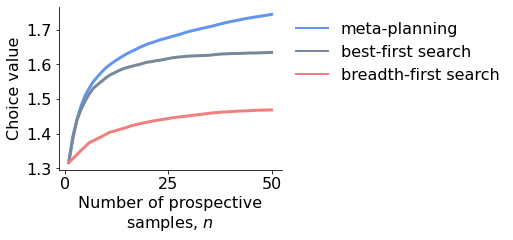

In [104]:
# Plot
fig, ax = plt.subplots(figsize=(4,3))
legend_elements = [Line2D([0], [0], color='cornflowerblue', lw=2, label='meta-planning'),
                   Line2D([0], [0], color='lightslategray', lw=2, label='best-first search'),
                  Line2D([0], [0], color='lightcoral', lw=2, label='breadth-first search')]
ax.legend(handles=legend_elements, frameon = False, bbox_to_anchor=(1,1), loc='upper left')

ax.plot(np.arange(1,51,1),np.average(M_T_seq_model_prev20,axis=1), color = 'cornflowerblue', lw=3)
ax.plot(np.arange(1,51,1),np.average(M_T_seq_bfs_prev20,axis=1), color = 'lightslategray', lw=3)
ax.plot(np.arange(1,51,1),np.average(M_T_seq_breadth_prev20,axis=1), color = 'lightcoral', lw=3)

ax.set_xticks([0,25,50])
# ax.set_yticks([0.8, 0.9, 1.0, 1.1])
ax.set_xlabel('Number of prospective\nsamples, $\it{n}$')
ax.set_ylabel('Choice value')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('4D_right.png', format='png', dpi=1000,bbox_inches = 'tight')

## 4-in-a-row simulations

In [86]:
# Set up retrospective experience
r = 0.25
a = 10
n = 18
Poisson_rates = [a*(1-r)**i for i in range(n)]
Poisson_rates

[10.0,
 7.5,
 5.625,
 4.21875,
 3.1640625,
 2.373046875,
 1.77978515625,
 1.3348388671875,
 1.001129150390625,
 0.7508468627929688,
 0.5631351470947266,
 0.4223513603210449,
 0.3167635202407837,
 0.23757264018058777,
 0.17817948013544083,
 0.13363461010158062,
 0.10022595757618546,
 0.0751694681821391]

In [88]:
# Alternatively, set retrospective experience to 0
Poisson_rates = [0 for i in range(n)]
Poisson_rates

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [89]:
# Set useful parameters
T_all = np.arange(1, 21, 1)
v_samples = 1000
game_length = 36
repeat_prob = 0.2

# Define a function with the parameters
def move_rts(moves, sigma_0, sigma_retro, sigma, cost):
    final_depth = np.zeros(18)
    count = 0
    for ii in moves:
        
        # Compute the number of actions available based on number of pieces on the board
        num_actions = int(game_length - ii)
        
        # Compute the Poisson rate for the retrospective samples
        Poisson_rate = np.random.binomial(num_actions, repeat_prob)

        var_running = np.ones(num_actions)*(sigma**2)

        # Run the generative model
        qbar_retro_all, q_1_all, n_samples_all, prior = gen_model_init(num_actions, sigma_0, sigma_retro, sigma, Poisson_rates[count], no_retro = False)
        
        # Array to store value of state based on action that is sampled
        M_T_curr = np.ones(num_actions)

        # Array to store time steps and sigmas
        T_action = np.ones(num_actions)

        # Compute useful values ahead of time
        J_0 = 1/sigma_0**2
        J_retro = 1/sigma_retro**2
        J = 1/sigma**2
        
        for T in T_all:
        
            # Compute J_a, mu, and sigma^2
            if T == 1:
                J_T = J_0 + J_retro*n_samples_all + J*T_action
                mu_T = (qbar_retro_all*J_retro*n_samples_all + q_1_all*J*T_action)/J_T
                var_running = 1/J_T
            else:
                J_T = 1/var_running

            # Loop through each action to consider sampling it
            for n in range(num_actions):
                mu_Tplus1, var_Tplus1, max_dist_Tplus1, M_Tplus1 = inference_action(mu_T, n, num_actions, J, J_T, v_samples)
                M_T_curr[n] = M_Tplus1

            # Max gain action
            max_prev = np.max(mu_T)
            gain_value = M_T_curr-max_prev
            max_value = np.max(gain_value)
            max_ind = np.argmax(gain_value)
            
            # Decide whether to sample or not
            curr_value = max_value-cost
            if curr_value > 0:
                
                # Update the counter for the action that was chosen and the ranked actions
                T_action[max_ind] += 1

                # Update the prospective value of the max gain action
                new_myopic = np.random.normal(prior[max_ind], sigma)

                # Update the posterior mean and variance with the new sample
                post_mean = ((mu_T[max_ind]*J_T[max_ind])+(J*new_myopic))/(J_T[max_ind]+J) 
                post_var = 1/(J_T[max_ind]+J)

                mu_T[max_ind] = post_mean
                var_running[max_ind] = post_var
            
            else:
                final_depth[count] = T
                break
                
        if final_depth[count] == 0:
            final_depth[count] = T
        
        count += 1
        
    return final_depth

In [90]:
# For now just choose a set of good parameters
moves = np.arange(1,37,2)
params_move_rts = [2, 10, 10, 0.1]

In [91]:
# Run simulations with the chosen parameters
num_sims = 1000
sim_rts = np.zeros((num_sims, 18))
for jj in range(num_sims):
    rts = move_rts(moves, *params_move_rts)
    sim_rts[jj,:] = rts

In [92]:
# For this, use the 0 retrospective experience setting
meta_noretro = np.average(sim_rts, axis=0)

In [93]:
with open('saved_analyses_online/meta_noretro.pickle', 'wb') as handle:
    pickle.dump(meta_noretro, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('saved_analyses_online/meta_noretro.pickle', 'rb') as handle:
    meta_noretro = pickle.load(handle)

In [50]:
# For this, use the retrospective experience setting
meta = np.average(sim_rts, axis=0)
meta_sem = stats.sem(sim_rts, axis=0)

In [52]:
with open('saved_analyses_online/meta.pickle', 'wb') as handle:
    pickle.dump(meta, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [96]:
with open('saved_analyses_online/meta.pickle', 'rb') as handle:
    meta = pickle.load(handle)

In [58]:
# Open analysis for reaction times per move
with open('/Users/ionatankuperwajs/Desktop/MaLab/Peak/Code/peak-analysis/saved_analyses_updated/move_reactiontimes.txt', 'r') as filehandle:  
    move_reactiontimes = json.load(filehandle)

In [60]:
# Calculate mean and standard error for each move number
move_avgs = np.zeros(36)
move_se = np.zeros(36)

for i in range(36):
    move_avgs[i] = np.mean(np.asarray(move_reactiontimes[str(i+1)]))
    move_se[i] = stats.sem(np.asarray(move_reactiontimes[str(i+1)]))
    
# Remove the nan values
move_avgs = move_avgs[~np.isnan(move_avgs)]
move_se = move_se[~np.isnan(move_se)]

# Z-score to normalize
move_avgs_norm = stats.zscore(move_avgs)
move_se_norm = move_se/np.std(move_avgs)

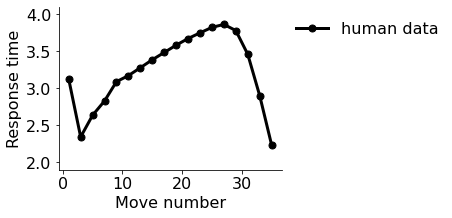

In [61]:
# Plot
fig, ax = plt.subplots(figsize=(4,3))
ax.set_ylim(1.9, 4.1)
# ax.set_yticks([2,3,4,5])
ax.plot(np.arange(1,37,2), move_avgs/1000, color='black', marker='o', ms=7, lw=3, label='human data')
# ax.fill_between(np.arange(1,37,2), user-user_sem, user+user_sem, alpha=0.2, color='black')
ax.set_xlabel('Move number')
ax.set_ylabel('Response time')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon = False, bbox_to_anchor=(1,1), loc='upper left')


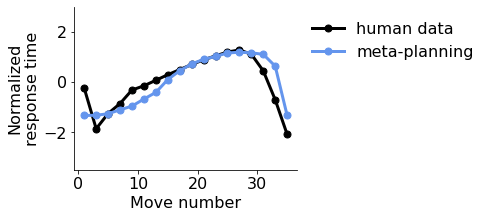

In [88]:
meta_norm = stats.zscore(meta)

fig, ax = plt.subplots(figsize=(4,3))
ax.set_ylim(-3.5, 3)
# ax.set_yticks([2,3,4,5])
ax.plot(np.arange(1,37,2), move_avgs_norm, color='black', marker='o', ms=7, lw=3, label='human data')
ax.plot(np.arange(1,37,2), meta_norm, color='cornflowerblue', marker='o', ms=7, lw=3, label='meta-planning')
# ax.fill_between(np.arange(1,37,2), user-user_sem, user+user_sem, alpha=0.2, color='black')
ax.set_xlabel('Move number')
ax.set_ylabel('Normalized\nresponse time')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon = False, bbox_to_anchor=(1,1), loc='upper left')
# plt.savefig('6B.png', format='png', dpi=1000,bbox_inches = 'tight')

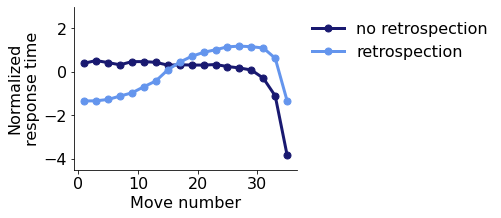

In [100]:
meta_norm_noretro = stats.zscore(meta_noretro)
meta_norm = stats.zscore(meta)

fig, ax = plt.subplots(figsize=(4,3))
ax.set_ylim(-4.5, 3)
# ax.set_yticks([2,3,4,5])
ax.plot(np.arange(1,37,2), meta_norm_noretro, color='midnightblue', marker='o', ms=7, lw=3, label='no retrospection')
ax.plot(np.arange(1,37,2), meta_norm, color='cornflowerblue', marker='o', ms=7, lw=3, label='retrospection')
# ax.fill_between(np.arange(1,37,2), user-user_sem, user+user_sem, alpha=0.2, color='black')
ax.set_xlabel('Move number')
ax.set_ylabel('Normalized\nresponse time')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon = False, bbox_to_anchor=(1,1), loc='upper left')
# plt.savefig('S5A.png', format='png', dpi=1000,bbox_inches = 'tight')

In [6]:
# Set useful parameters
T_all = np.arange(1, 21, 1)
v_samples = 1000
num_actions = 36

# Define a function with the parameters
def retro_rts(Poisson_rates, sigma_0, sigma_retro, sigma, cost):
    final_depth = np.zeros(len(Poisson_rates))
    count = 0
    for ii in Poisson_rates:

        var_running = np.ones(num_actions)*(sigma**2)

        # Run the generative model
        qbar_retro_all, q_1_all, n_samples_all, prior = gen_model_init(num_actions, sigma_0, sigma_retro, sigma, Poisson_rates[ii], no_retro = False)
        
        # Array to store value of state based on action that is sampled
        M_T_curr = np.ones(num_actions)

        # Array to store time steps and sigmas
        T_action = np.ones(num_actions)

        # Compute useful values ahead of time
        J_0 = 1/sigma_0**2
        J_retro = 1/sigma_retro**2
        J = 1/sigma**2
        
        for T in T_all:
        
            # Compute J_a, mu, and sigma^2
            if T == 1:
                J_T = J_0 + J_retro*n_samples_all + J*T_action
                mu_T = (qbar_retro_all*J_retro*n_samples_all + q_1_all*J*T_action)/J_T
                var_running = 1/J_T
            else:
                J_T = 1/var_running

            # Loop through each action to consider sampling it
            for n in range(num_actions):
                mu_Tplus1, var_Tplus1, max_dist_Tplus1, M_Tplus1 = inference_action(mu_T, n, num_actions, J, J_T, v_samples)
                M_T_curr[n] = M_Tplus1

            # Max gain action
            max_prev = np.max(mu_T)
            gain_value = M_T_curr-max_prev
            max_value = np.max(gain_value)
            max_ind = np.argmax(gain_value)
            
            # Decide whether to sample or not
            curr_value = max_value-cost
            if curr_value > 0:
                
                # Update the counter for the action that was chosen and the ranked actions
                T_action[max_ind] += 1

                # Update the prospective value of the max gain action
                new_myopic = np.random.normal(prior[max_ind], sigma)

                # Update the posterior mean and variance with the new sample
                post_mean = ((mu_T[max_ind]*J_T[max_ind])+(J*new_myopic))/(J_T[max_ind]+J) 
                post_var = 1/(J_T[max_ind]+J)

                mu_T[max_ind] = post_mean
                var_running[max_ind] = post_var
            
            else:
                final_depth[count] = T
                break
                
        if final_depth[count] == 0:
            final_depth[count] = T
        
        count += 1
        
    return final_depth

In [143]:
# For now just choose a set of good parameters
Poisson_rates = np.arange(0, 10, 1)
params_retro_rts = [2, 10, 10, 0.1]

In [8]:
# Run simulations with the optimal parameters
num_sims = 1000
sim_rts = np.zeros((num_sims, 10))

for jj in range(num_sims):
    rts = retro_rts(Poisson_rates, *params_retro_rts)
    sim_rts[jj,:] = rts

/Users/ionatankuperwajs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


In [9]:
# Take the average and SEM
theory_open = np.average(sim_rts, axis=0)
theory_sem = stats.sem(sim_rts, axis=0)

In [35]:
with open('saved_analyses_online/theory_open.pickle', 'wb') as handle:
    pickle.dump(theory_open, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [56]:
with open('saved_analyses_online/theory_open.pickle', 'rb') as handle:
    theory_open = pickle.load(handle)

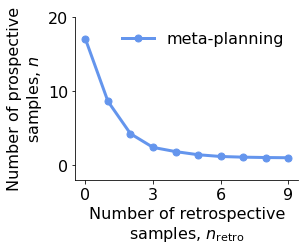

In [57]:
# Plot
fig, ax = plt.subplots(figsize=(4,3))
ax.set_ylim(-2,20)
ax.set_yticks([0,10,20])
ax.set_xticks([0,3,6,9])
ax.plot(np.arange(0,10,1), theory_open, marker='o', ms=7, lw=3, color='cornflowerblue', label='meta-planning')
ax.set_xlabel('Number of retrospective\nsamples, $n_{\mathrm{retro}}$')
ax.set_ylabel('Number of prospective\nsamples, $\it{n}$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon = False, loc='upper right')


In [50]:
# Open move RTs
with open('../../../Peak/Code/peak-analysis/saved_analyses_updated/opening_RT.txt', 'r') as filehandle:  
    opening_RT = json.load(filehandle)

In [51]:
# Loop through all of the users and build a list of lists with RTs per reptitions
RT_open = []
new_count = set()

for user in opening_RT.keys():
    count = 0
    for value in opening_RT[user]:
        # If the reptition is new, create a new list with the RT
        if count not in new_count:
            # Add them to the new users set
            new_count.add(count)
            
            RT_open.append([value])

        # If the repetition isn't new, append the RT to the right dictionary
        else:
            RT_open[count].append(value)
        count += 1

In [52]:
# Calculate mean and standard error for each configuration repetition
open_avgs = np.zeros(10)
open_se = np.zeros(10)
open_rep = np.zeros(10)

for i in range(0,10):
    open_avgs[i] = np.mean(np.asarray(RT_open[i]))
    open_se[i] = stats.sem(np.asarray(RT_open[i]))
    open_rep[i] = len(RT_open[i])
    
# Divide by 1000 to get into seconds and Z-score to normalize
open_avgs = open_avgs/1000
open_se = open_se/1000
open_norm = stats.zscore(open_avgs)
se_open = open_se/np.std(open_avgs)

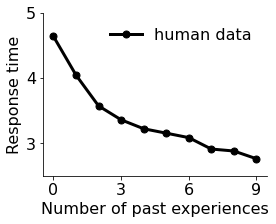

In [53]:
# Plot
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(np.arange(0,10,1), open_avgs, marker='o', ms=7, lw=3, color='black', label='human data')
# ax.plot(np.arange(0,10,1), theory_open, color='midnightblue', lw=3, label='meta-planning', zorder=0)
ax.set_ylim(2.5,5)
ax.set_yticks([3,4,5])
ax.set_xticks([0,3,6,9])
ax.set_xlabel('Number of past experiences')
ax.set_ylabel('Response time')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon = False, loc='upper right')


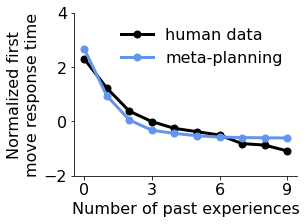

In [60]:
theory_open_norm = stats.zscore(theory_open)

# Plot
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(np.arange(0,10,1), open_norm, marker='o', ms=7, lw=3, color='black', label='human data')
ax.plot(np.arange(0,10,1), theory_open_norm, marker='o', ms=7, lw=3, color='cornflowerblue',label='meta-planning')
ax.set_ylim(-2,4)
# ax.set_yticks([2,2.5])
ax.set_xticks([0,3,6,9])
ax.set_xlabel('Number of past experiences')
ax.set_ylabel('Normalized first\nmove response time')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon = False, loc='upper right')
# plt.savefig('S5B.png', format='png', dpi=1000,bbox_inches = 'tight')

In [144]:
# Run simulations with the optimal parameters
num_sims = 1000
num_actions = 34
sim_rts = np.zeros((num_sims, 10))

for jj in range(num_sims):
    rts = retro_rts(Poisson_rates, *params_retro_rts)
    sim_rts[jj,:] = rts

# Take the average and SEM
theory_third = np.average(sim_rts, axis=0)
theory_sem = stats.sem(sim_rts, axis=0)

/Users/ionatankuperwajs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


In [150]:
with open('saved_analyses_online/theory_third.pickle', 'wb') as handle:
    pickle.dump(theory_third, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
with open('saved_analyses_online/theory_third.pickle', 'rb') as handle:
    theory_third = pickle.load(handle)

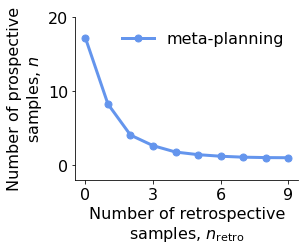

In [55]:
# Plot
fig, ax = plt.subplots(figsize=(4,3))
ax.set_ylim(-2,20)
ax.set_yticks([0,10,20])
ax.set_xticks([0,3,6,9])
ax.plot(np.arange(0,10,1), theory_third, marker='o', ms=7, lw=3, color='cornflowerblue', label='meta-planning')
ax.set_xlabel('Number of retrospective\nsamples, $n_{\mathrm{retro}}$')
ax.set_ylabel('Number of prospective\nsamples, $\it{n}$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon = False, loc='upper right')
# plt.savefig('4C_third_meta.png', format='png', dpi=1000,bbox_inches = 'tight')

In [126]:
# Open two-move RTs
with open('../../../Peak/Code/peak-analysis/saved_analyses_updated/opening_twomoves_react.txt', 'r') as filehandle:  
    opening_twomoves_react = json.load(filehandle)

In [127]:
# Loop through all of the user 2-ply configs and third move RTs. First initialize a large container list to hold 
# tuples of the RTs per move.
RT_container = []

for user, value in opening_twomoves_react.items():
    # Isolate the 2-ply configs
    move_configs = [move_RT[0] for move_RT in value]
    # Get the unique move configs, and then their indices from the original list
    move_configs = [tuple(ele) for ele in move_configs]
    unique_configs = set(move_configs)
    config_indices = { v : [ moves for moves, index in enumerate(move_configs) if index == v ]
            for v in unique_configs }
    # Grab the RTs for each index, group them sequentially, and append to a list
    for curr_move, curr_index in config_indices.items():
        temp_list = []
        for ind in curr_index:
            temp_list.append(value[ind][1])    
        RT_container.append(temp_list)

In [128]:
# Loop through and collect all of the RTs for each config appearance in its own list. Store each list 
# in a container dict.
container_thirdmoveRT = []

for n in range(0, 100):
    container_thirdmoveRT.append([])
    
for n in range(0, 100):
    for j in RT_container:
        for z in range(len(j)):
            if z == n:
                container_thirdmoveRT[n].append(j[z])

In [129]:
# Calculate mean and standard error for each configuration repetition
third_avgs = np.zeros(10)
third_se = np.zeros(10)
third_rep = np.zeros(10)

for i in range(0,10):
    third_avgs[i] = np.mean(np.asarray(container_thirdmoveRT[i]))
    third_se[i] = stats.sem(np.asarray(container_thirdmoveRT[i]))
    third_rep[i] = len(container_thirdmoveRT[i])
    
# Divide by 1000 to get into seconds Z-score to normalize
third_avgs = third_avgs/1000
third_se = third_se/1000
third_norm = stats.zscore(third_avgs)
se_third = third_se/np.std(third_avgs)

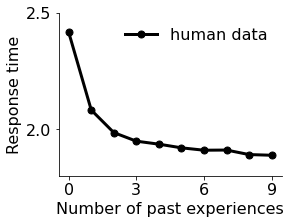

In [133]:
# Plot
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(np.arange(0,10,1), third_avgs, marker='o', ms=7, lw=3, color='black', label='human data')
ax.set_ylim(1.8,2)
ax.set_yticks([2,2.5])
ax.set_xticks([0,3,6,9])
ax.set_xlabel('Number of past experiences')
ax.set_ylabel('Response time')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon = False, loc='upper right')


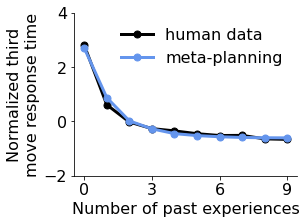

In [138]:
theory_third_norm = stats.zscore(theory_third)

# Plot
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(np.arange(0,10,1), third_norm, marker='o', ms=7, lw=3, color='black', label='human data')
ax.plot(np.arange(0,10,1), theory_third_norm, marker='o', ms=7, lw=3, color='cornflowerblue',label='meta-planning')
ax.set_ylim(-2,4)
# ax.set_yticks([2,2.5])
ax.set_xticks([0,3,6,9])
ax.set_xlabel('Number of past experiences')
ax.set_ylabel('Normalized third\nmove response time')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon = False, loc='upper right')
# plt.savefig('6C.png', format='png', dpi=1000,bbox_inches = 'tight')

In [5]:
# Open analysis for reaction times per move
with open('/Users/ionatankuperwajs/Desktop/MaLab/Peak/Code/peak-analysis/saved_analyses_updated/move_reactiontimes1.txt', 'r') as filehandle:  
    move_reactiontimes1 = json.load(filehandle)
    
with open('/Users/ionatankuperwajs/Desktop/MaLab/Peak/Code/peak-analysis/saved_analyses_updated/move_reactiontimes50.txt', 'r') as filehandle:  
    move_reactiontimes50 = json.load(filehandle)

In [6]:
# Calculate mean and standard error for each move number
move_avgs1 = np.zeros(36)
move_se1 = np.zeros(36)

move_avgs50 = np.zeros(36)
move_se50 = np.zeros(36)

for i in range(36):
    move_avgs1[i] = np.mean(np.asarray(move_reactiontimes1[str(i+1)]))
    move_se1[i] = stats.sem(np.asarray(move_reactiontimes1[str(i+1)]))
    
    move_avgs50[i] = np.mean(np.asarray(move_reactiontimes50[str(i+1)]))
    move_se50[i] = stats.sem(np.asarray(move_reactiontimes50[str(i+1)]))
    
# Remove the nan values
move_avgs1 = move_avgs1[~np.isnan(move_avgs1)]
move_se1 = move_se1[~np.isnan(move_se1)]

move_avgs50 = move_avgs50[~np.isnan(move_avgs50)]
move_se50 = move_se50[~np.isnan(move_se50)]

/Users/ionatankuperwajs/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ionatankuperwajs/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ionatankuperwajs/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/ionatankuperwajs/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/ionatankuperwajs/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


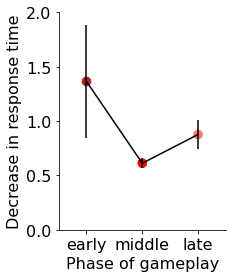

In [32]:
# Plot

game_diff = [np.average(move_avgs1[0:3] - move_avgs50[0:3])/1000,np.average(move_avgs1[3:15] - move_avgs50[3:15])/1000, np.average(move_avgs1[15:18] - move_avgs50[15:18])/1000]
game_error = [stats.sem(move_avgs1[0:3] - move_avgs50[0:3])/1000,stats.sem(move_avgs1[3:15] - move_avgs50[3:15])/1000, stats.sem(move_avgs1[15:18] - move_avgs50[15:18])/1000]

fig, ax = plt.subplots(figsize=(3,4))
ax.scatter(np.arange(1,4),game_diff, color=['firebrick', 'red', 'salmon'], s=75)
ax.errorbar(np.arange(1,4),game_diff, yerr=game_error, color='black')
# ax.errorbar(np.arange(1,4),game_diff, yerr = game_error, color='black', ecolor='black', markerfacecolor='firebrick', markeredgecolor='firebrick', marker='o', ms=7, lw=1)
ax.set_xlim(.5,3.5)
ax.set_xticks([1,2,3])
ax.set_yticks([0, .5, 1, 1.5, 2])
ax.set_xticklabels(['early','middle','late'])
ax.set_xlabel('Phase of gameplay')
ax.set_ylabel('Decrease in response time')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('6E.png', format='png', dpi=1000,bbox_inches = 'tight')

In [31]:
print(stats.ttest_ind(move_avgs1[0:3] - move_avgs50[0:3], move_avgs1[3:15] - move_avgs50[3:15]))
print(stats.ttest_ind(move_avgs1[0:3] - move_avgs50[0:3], move_avgs1[15:18] - move_avgs50[15:18]))
print(stats.ttest_ind(move_avgs1[3:15] - move_avgs50[3:15], move_avgs1[15:18] - move_avgs50[15:18]))

Ttest_indResult(statistic=3.0654469417027457, pvalue=0.00902760795373649)
Ttest_indResult(statistic=0.9128773158927196, pvalue=0.4129513820567643)
Ttest_indResult(statistic=-2.429703647068937, pvalue=0.030347769523557583)


In [3]:
# Open analysis for reaction times per experience level
with open('/Users/ionatankuperwajs/Desktop/MaLab/Peak/Code/peak-analysis/saved_analyses_updated/reactiontimes0.txt', 'r') as filehandle:  
    rt_bin0 = json.load(filehandle)
    
with open('/Users/ionatankuperwajs/Desktop/MaLab/Peak/Code/peak-analysis/saved_analyses_updated/reactiontimes10.txt', 'r') as filehandle:  
    rt_bin10 = json.load(filehandle)
    
with open('/Users/ionatankuperwajs/Desktop/MaLab/Peak/Code/peak-analysis/saved_analyses_updated/reactiontimes20.txt', 'r') as filehandle:  
    rt_bin20 = json.load(filehandle)
    
with open('/Users/ionatankuperwajs/Desktop/MaLab/Peak/Code/peak-analysis/saved_analyses_updated/reactiontimes30.txt', 'r') as filehandle:  
    rt_bin30 = json.load(filehandle)
    
with open('/Users/ionatankuperwajs/Desktop/MaLab/Peak/Code/peak-analysis/saved_analyses_updated/reactiontimes40.txt', 'r') as filehandle:  
    rt_bin40 = json.load(filehandle)
    
with open('/Users/ionatankuperwajs/Desktop/MaLab/Peak/Code/peak-analysis/saved_analyses_updated/reactiontimes50.txt', 'r') as filehandle:  
    rt_bin50 = json.load(filehandle)

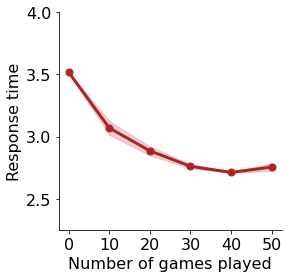

In [10]:
# Plot
game_rts = np.asarray([np.average(rt_bin0)/1000, np.average(rt_bin10)/1000, np.average(rt_bin20)/1000, 
            np.average(rt_bin30)/1000, np.average(rt_bin40)/1000, np.average(rt_bin50)/1000])
game_errors = np.asarray([stats.sem(rt_bin0)/1000, stats.sem(rt_bin10)/1000, stats.sem(rt_bin20)/1000, 
            stats.sem(rt_bin30)/1000, stats.sem(rt_bin40)/1000, stats.sem(rt_bin50)/1000])

fig, ax = plt.subplots(figsize=(4,4))
# ax.scatter(np.arange(1,7),game_rts, color=['black','maroon','firebrick','red','salmon','lightsalmon'], s=75)
# ax.errorbar(np.arange(1,7),game_rts, yerr=game_errors, color='black')
ax.plot(np.arange(1,7),game_rts, color='firebrick', marker='o', ms=7, lw=3)
ax.fill_between(np.arange(1,7),game_rts-game_errors, game_rts+game_errors, alpha=0.2, color='firebrick')
ax.set_ylim(2.25,4)
ax.set_xticks([1,2,3,4,5,6])
ax.set_yticks([2.5, 3,3.5,4])
ax.set_xticklabels(['0','10','20','30','40','50'])
ax.set_xlabel('Number of games played')
ax.set_ylabel('Response time')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('6D.png', format='png', dpi=1000,bbox_inches = 'tight')

## Additional simulations

In [5]:
with open('saved_analyses_online/M_T_max_actions.pickle', 'rb') as handle:
    M_T_max_actions = pickle.load(handle)
    
with open('saved_analyses_online/gap_dist.pickle', 'rb') as handle:
    gap_dist = pickle.load(handle)
    
with open('saved_analyses_online/T_ranked_gap.pickle', 'rb') as handle:
    T_ranked_gap = pickle.load(handle)

In [9]:
# Set variables and ranges
num_sims = 10000
cost = .05
T_steps = 21
T_all = np.arange(1, T_steps, 1)  # number of total time steps to run
num_actions = np.arange(2, 21, 1)

# Compute net value for a single cost
action_samples_total = np.zeros((len(num_actions),len(T_all)))
action_samples_count = np.zeros((len(num_actions),len(T_all)))
            
# Loop through the simulations and compute whether it is worthwhile to expand
for ii in range(num_sims):
    for jj in range(len(num_actions)):
        for T in T_all:
            curr_value = M_T_max_actions[T-1,ii,jj]-cost
            if curr_value > 0:
                action_samples_total[jj, T-1] += 1
            action_samples_count[jj, T-1] += 1
        
action_samples_final = action_samples_total/action_samples_count

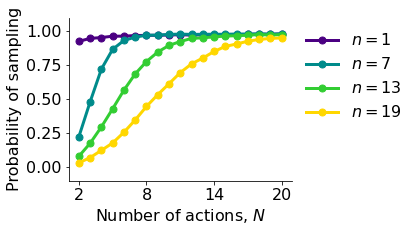

In [16]:
# Plot
fig, ax = plt.subplots(figsize=(4,3))
ax.set_ylim(-.1,1.1)
ax.set_yticks([0,.25,0.5,0.75,1])
ax.set_xticks([2,8,14,20])
ax.plot(num_actions, action_samples_final[:,0], marker='o', ms=7, lw=3, color='indigo', label='$n=1$')
ax.plot(num_actions, action_samples_final[:,6], marker='o', ms=7, lw=3, color='darkcyan', label='$n=7$')
ax.plot(num_actions, action_samples_final[:,12], marker='o', ms=7, lw=3, color='limegreen', label='$n=13$')
ax.plot(num_actions, action_samples_final[:,18], marker='o', ms=7, lw=3, color='gold', label='$n=19$')
ax.set_xlabel('Number of actions, $N$')
ax.set_ylabel('Probability of sampling')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon = False, bbox_to_anchor=(1,1), loc='upper left')

# plt.savefig('S2A.png', format='png', dpi=1000,bbox_inches = 'tight')

In [6]:
# Helper function to map numbers to the nearest divisor
def round_down(num, divisor):
    return num - (num%divisor)

# Set variables and ranges
num_sims = 10000
cost = .05
gap_range = np.arange(0,8.5,0.125)
T_steps = 21
T_all = np.arange(1, T_steps, 1)  # number of total time steps to run
action_ind = 3

# Compute net value for a single cost
gap_samples_total = np.zeros((len(gap_range),len(T_all)))
gap_samples_count = np.zeros((len(gap_range),len(T_all)))
            
# Loop through the simulations and compute whether it is worthwhile to expand
for ii in range(num_sims):
    for T in T_all:
        curr_gap = gap_dist[T-1, ii, action_ind]
        curr_value = M_T_max_actions[T-1,ii,action_ind]-cost
        gap_ind = np.where(gap_range == round_down(curr_gap,.125))[0][0]
        if curr_value > 0:
            gap_samples_total[gap_ind, T-1] += 1
        gap_samples_count[gap_ind, T-1] += 1
        
gap_samples_final = gap_samples_total/gap_samples_count


/Users/ionatankuperwajs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


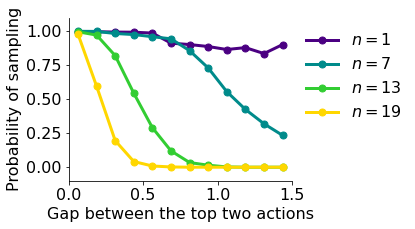

In [49]:
# Plot
fig, ax = plt.subplots(figsize=(4,3))
ax.set_xlim(0,1.5)
ax.set_ylim(-.1,1.1)
ax.set_yticks([0,.25,0.5,0.75,1])
ax.set_xticks([0,0.5, 1, 1.5])
ax.plot(np.arange(0,1.5,.125)+.0625, gap_samples_final[0:12,0], marker='o', ms=7, lw=3, color='indigo', label='$n=1$')
ax.plot(np.arange(0,1.5,.125)+.0625, gap_samples_final[0:12,6], marker='o', ms=7, lw=3, color='darkcyan', label='$n=7$')
ax.plot(np.arange(0,1.5,.125)+.0625, gap_samples_final[0:12,12], marker='o', ms=7, lw=3, color='limegreen', label='$n=13$')
ax.plot(np.arange(0,1.5,.125)+.0625, gap_samples_final[0:12,18], marker='o', ms=7, lw=3, color='gold', label='$n=19$')
ax.set_xlabel('Gap between the top two actions')
ax.set_ylabel('Probability of sampling')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon = False, bbox_to_anchor=(1,1), loc='upper left')
# plt.savefig('S2B.png', format='png', dpi=1000,bbox_inches = 'tight')